**Credit plays a central role in the global economy, powering consumer spending, business expansion, and national economic development. From personal loans to corporate financing, the credit industry moves trillions of dollars worldwide each year. Hence, effective credit risk assessment is crucial for lenders. By accurately identifying borrowers who are more likely to repay, lenders can minimize losses, preserve capital, and unlock new opportunities through responsible lending.**

**Traditionally, credit risk has been assessed using rule-based systems or basic statistical models, which often rely heavily on a few variables like credit scores or income. While these methods have been effective to an extent, they may overlook complex patterns and interactions in borrower behavior, potentially excluding creditworthy individuals with unconventional profiles. Modern machine learning methods offer the ability to improve predictive accuracy and enable more inclusive credit allocation without compromising risk management.**

**This data science project explores typical data collected by banks and lending institutions and uses these data to build a robust credit risk assessment tool. Specifically, this project aims to:**
- **Determine whether the available data categories influence the interest rate and loan amount offered by lenders**
- **Identify which factors are associated with a high risk of default**
- **Build a machine learning model that reliably predicts good payers and defaulters**
- **Develop an optimal strategy that maximizes profit and minimizes loss**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, roc_curve, classification_report, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

**The dataset used was obtained from Kaggle. You can access it at https://www.kaggle.com/datasets/nanditapore/credit-risk-analysis/data**

In [4]:
df = pd.read_csv("/Users/jmtee/Desktop/Kaggle Datasets/credit_risk.csv")

**I did a quick check on the columns and discarded the *Id* column, as it essentially served only as an index for each entry.**

In [6]:
df.head()

,Id,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,0,22,59000,RENT,2.0,PERSONAL,35000,16.02,1,0.59,Y,3
1,1,21,9600,OWN,5.0,EDUCATION,1000,11.14,0,0.10,N,2
2,2,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,1,0.57,N,3
3,3,23,65500,RENT,4.0,MEDICAL,35000,15.23,1,0.53,N,2
4,4,24,54400,RENT,8.0,MEDICAL,35000,14.27,1,0.55,Y,4


In [7]:
df.drop(columns=['Id'], inplace=True)
df.head()

,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,22,59000,RENT,2.0,PERSONAL,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,35000,14.27,1,0.55,Y,4


**An info check revealed that all columns were in the correct data types. The *Emp_length* column, which reflects a client's employment length in years, could have been converted to a more suitable integer type; however, I chose to leave it as is (float type) since this would not affect any downstream processing steps. There were three object-type columns, which were ultimately one-hot encoded so they could be incorporated into the machine learning algorithms used for credit risk modeling.**

**Upon examining nulls, missing values were found in *Emp_length* and *Rate*. Ideally, we would impute these missing values so they could be included in modeling as well. However, I decided not to do so in this case, as I wanted the analysis to rely solely on native dataset values. Additionally, lacking strong domain knowledge, I was not confident in explaining any potential unusual results that might arise from the influence of imputed values. Nevertheless, the dataset was large enough to draw meaningful insights from, even after excluding the entries with nulls.**

In [9]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             32581 non-null  int64  
 1   Income          32581 non-null  int64  
 2   Home            32581 non-null  object 
 3   Emp_length      31686 non-null  float64
 4   Intent          32581 non-null  object 
 5   Amount          32581 non-null  int64  
 6   Rate            29465 non-null  float64
 7   Status          32581 non-null  int64  
 8   Percent_income  32581 non-null  float64
 9   Default         32581 non-null  object 
 10  Cred_length     32581 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 2.7+ MB


Age                  0
Income               0
Home                 0
Emp_length         895
Intent               0
Amount               0
Rate              3116
Status               0
Percent_income       0
Default              0
Cred_length          0
dtype: int64

In [10]:
df[df['Rate'].isnull()]

,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
39,23,71500,RENT,3.0,DEBTCONSOLIDATION,30000,NaN,1,0.42,N,4
50,24,78000,RENT,4.0,DEBTCONSOLIDATION,30000,NaN,1,0.38,Y,4
57,23,277000,OWN,3.0,PERSONAL,35000,NaN,0,0.13,N,4
59,24,12000,OWN,2.0,VENTURE,1750,NaN,0,0.15,Y,3
62,26,263000,MORTGAGE,0.0,EDUCATION,10000,NaN,1,0.04,N,4
...,...,...,...,...,...,...,...,...,...,...,...
32547,53,4888,OWN,0.0,VENTURE,1400,NaN,1,0.29,Y,28
32552,65,45900,RENT,2.0,EDUCATION,10000,NaN,0,0.22,Y,19
32553,54,20000,RENT,2.0,MEDICAL,5000,NaN,0,0.25,N,28
32569,51,60000,MORTGAGE,1.0,PERSONAL,7500,NaN,0,0.13,N,23


**Checking for duplicates, we found that the duplicate pairs were typically not adjacent. It's worth noting that no duplicates would have surfaced if the *Id* column had still been present.**

In [12]:
df.duplicated().sum()

165

In [13]:
dupes = df[df.duplicated(keep=False)]
dupes = dupes.sort_values(by=df.columns.tolist())
dupes.head(20)

,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
15944,21,8088,RENT,NaN,MEDICAL,1200,15.23,0,0.15,Y,2
16835,21,8088,RENT,NaN,MEDICAL,1200,15.23,0,0.15,Y,2
2431,21,15600,RENT,0.0,MEDICAL,2800,7.40,1,0.18,N,4
17758,21,15600,RENT,0.0,MEDICAL,2800,7.40,1,0.18,N,4
2498,21,18000,RENT,0.0,DEBTCONSOLIDATION,3000,7.90,1,0.17,N,2
17601,21,18000,RENT,0.0,DEBTCONSOLIDATION,3000,7.90,1,0.17,N,2
1778,21,20000,RENT,0.0,MEDICAL,2000,NaN,0,0.10,N,3
17642,21,20000,RENT,0.0,MEDICAL,2000,NaN,0,0.10,N,3
740,21,21600,OWN,NaN,VENTURE,7125,6.99,0,0.33,N,3
17283,21,21600,OWN,NaN,VENTURE,7125,6.99,0,0.33,N,3


In [14]:
df = df.drop_duplicates()
df.duplicated().sum()

0

**After cleaning the dataset, I saved a copy of the dataframe that retained the original object-type columns as *df_raw*. This version would be used for the visualization and analysis of frequency and distribution of the relevant categorical variables. I also created another copy, named *df_encoded*, wherein all categorical variables were one-hot encoded. This version would be used for numerical analyses and model training.**

In [16]:
df_raw = df.copy()

In [17]:
df_encoded = df.copy()
df_encoded['Default'] = df_encoded['Default'].map({'Y': 1, 'N': 0})
df_encoded = pd.get_dummies(df_encoded, columns=['Home', 'Intent'], drop_first=False)
df_encoded.head()

,Age,Income,Emp_length,Amount,Rate,Status,Percent_income,Default,Cred_length,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE
0,22,59000,2.0,35000,16.02,1,0.59,1,3,False,False,False,True,False,False,False,False,True,False
1,21,9600,5.0,1000,11.14,0,0.10,0,2,False,False,True,False,False,True,False,False,False,False
2,25,9600,1.0,5500,12.87,1,0.57,0,3,True,False,False,False,False,False,False,True,False,False
3,23,65500,4.0,35000,15.23,1,0.53,0,2,False,False,False,True,False,False,False,True,False,False
4,24,54400,8.0,35000,14.27,1,0.55,1,4,False,False,False,True,False,False,False,True,False,False


In [18]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32416 entries, 0 to 32580
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       32416 non-null  int64  
 1   Income                    32416 non-null  int64  
 2   Emp_length                31529 non-null  float64
 3   Amount                    32416 non-null  int64  
 4   Rate                      29321 non-null  float64
 5   Status                    32416 non-null  int64  
 6   Percent_income            32416 non-null  float64
 7   Default                   32416 non-null  int64  
 8   Cred_length               32416 non-null  int64  
 9   Home_MORTGAGE             32416 non-null  bool   
 10  Home_OTHER                32416 non-null  bool   
 11  Home_OWN                  32416 non-null  bool   
 12  Home_RENT                 32416 non-null  bool   
 13  Intent_DEBTCONSOLIDATION  32416 non-null  bool   
 14  Intent_EDUC

In [19]:
print("Raw shape:", df_raw.shape)
print("Encoded shape:", df_encoded.shape)

Raw shape: (32416, 11)
Encoded shape: (32416, 19)


# **EXPLORATORY DATA ANALYSIS AND VISUALIZATION**

In [21]:
df_encoded.describe()

,Age,Income,Emp_length,Amount,Rate,Status,Percent_income,Default,Cred_length
count,32416.000000,3.241600e+04,31529.000000,32416.000000,29321.000000,32416.000000,32416.000000,32416.000000,32416.000000
mean,27.731583,6.609164e+04,4.782835,9593.845632,11.017265,0.218688,0.170250,0.176765,5.811297
std,6.212052,6.201558e+04,4.037215,6322.730241,3.241680,0.413363,0.106812,0.381475,4.059030
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,0.000000,2.000000
25%,23.000000,3.854200e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,0.000000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,0.000000,4.000000
75%,30.000000,7.921800e+04,7.000000,12250.000000,13.470000,0.000000,0.230000,0.000000,8.000000
max,94.000000,6.000000e+06,41.000000,35000.000000,23.220000,1.000000,0.830000,1.000000,30.000000


**After data preparation, I created exploratory visualizations to examine the distribution of values in the numerical columns. For this, I chose to use violin plots to easily view central tendency statistics along with distribution. The plots clearly showed that *Income* was heavily skewed by a few extreme values, notably one around 6 million. Similarly, *Age* was skewed by outliers up to above 90, distorting the main distribution centered around ages 20–30. To address this, I filtered the dataset to include only values between the 5th and 95th percentiles. This trimmed version was used for visualization and regression analysis, where extreme values could significantly impact results. For risk modeling, however, the full dataset, including outliers, was retained.**

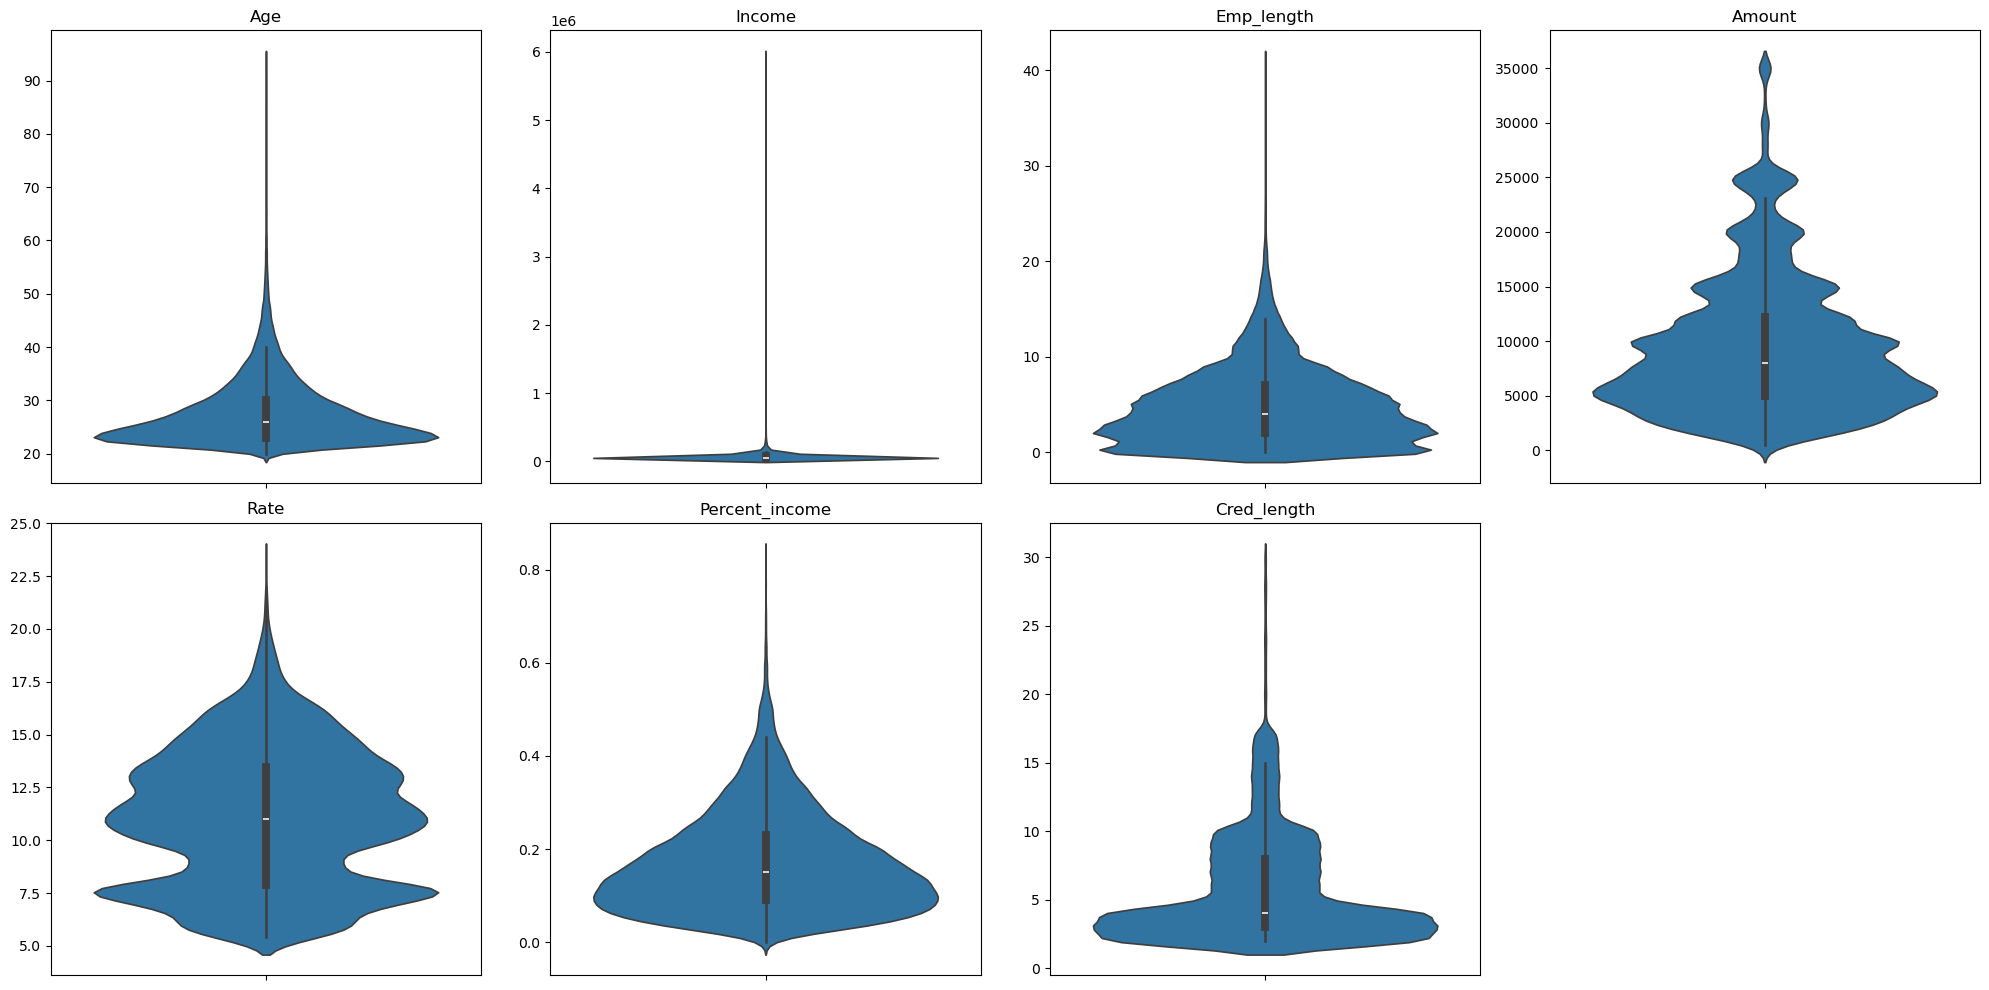

In [23]:
numeric_cols = ['Age', 'Income', 'Emp_length', 'Amount', 'Rate', 'Percent_income', 'Cred_length']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.violinplot(y=df_encoded[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel('')

for j in range(len(numeric_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [24]:
def remove_outliers_quantile(df, column, lower_q=0.005, upper_q=0.995):
    lower = df[column].quantile(lower_q)
    upper = df[column].quantile(upper_q)
    return df[(df[column] >= lower) & (df[column] <= upper)]

df_cleaned = df_encoded.copy()
df_cleaned = remove_outliers_quantile(df_cleaned, 'Age')
df_cleaned = remove_outliers_quantile(df_cleaned, 'Income')

**After filtering the outliers, we can now better describe the numerical columns. We are left with a client pool that consists mainly of individuals aged 20 to 55, with incomes up to \$300,000. Most applicants are relatively young and, as a result, have shorter employment (*Emp_length*) and credit histories (*Cred_length*), mostly 5 years or less. The majority of loans are for amounts of \\$10,000 or less, though it may reach up to $35,000. Interest rates vary widely between 5% and 25%, but over half of applicants receive rates below 12%. Finally, we can infer that most clients manage their leverage cautiously, with more than half borrowing only about one-fifth of their income.**

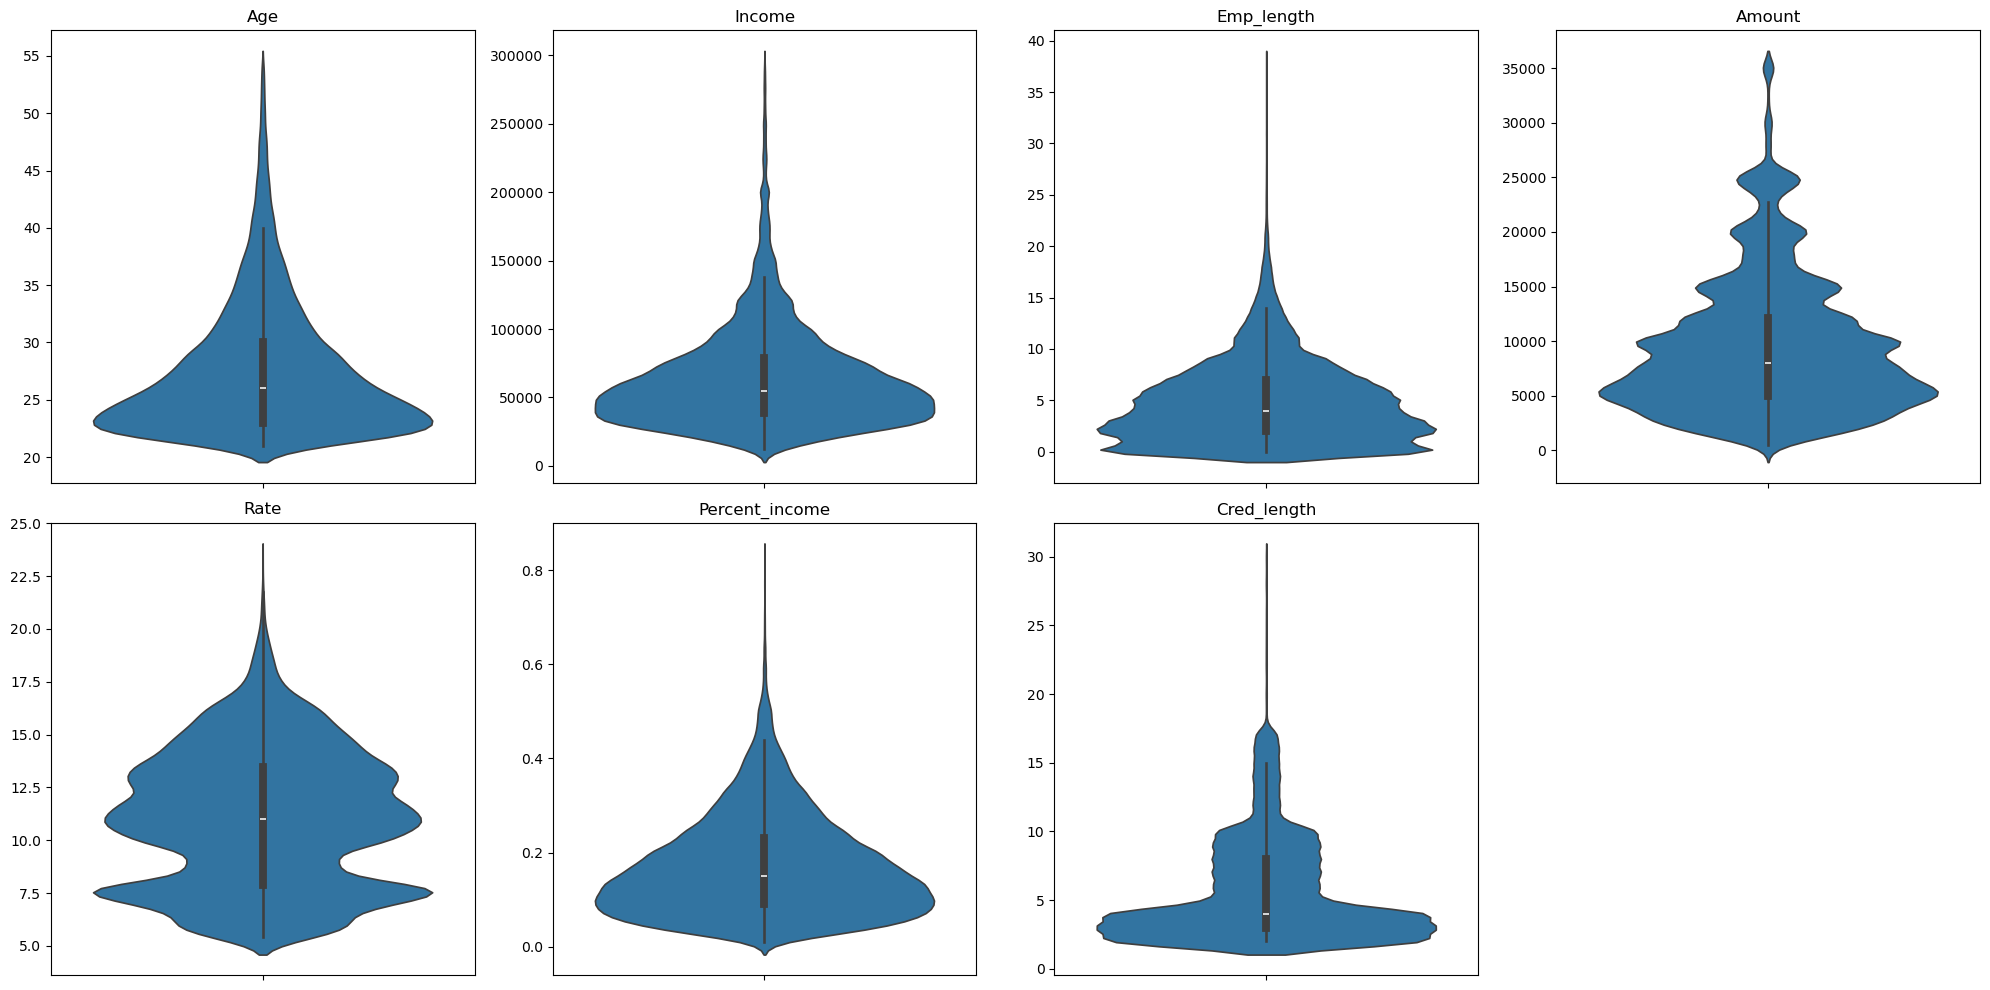

In [26]:
numeric_cols = ['Age', 'Income', 'Emp_length', 'Amount', 'Rate', 'Percent_income', 'Cred_length']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.violinplot(y=df_cleaned[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel('')

for j in range(len(numeric_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

**I then examined the distribution of values based on the client’s current default status (*Status*). These visuals provide early insights into potential default predictors, which can later be confirmed through statistical and machine learning methods. Based on the plots, we can observe no visible difference in default rates when considering age alone. For income, however, there was a prominent concentration of defaulters at under \\$50,000. Additionally, the median income for good payers was above \\$50,000, while it was below this threshold for defaulters, suggesting that clients earning less than \\$50,000 might be regarded as higher risk. Interestingly, defaults still occurred among clients earning over \$100,000.**

**Similarly, defaulters showed a more pronounced peak among those with shorter employment histories, indicating that short-tenured applicants may have a slightly higher risk of default. Defaults were still observed among those employed for 15 years or more, though notably, clients with over 30 years of employment appeared to be risk-free. In contrast, credit history length did not show any clear visible difference between defaulters and non-defaulters, suggesting that clients with similar credit histories were equally likely to pay or default. When examining loan amounts, loans of \$5,000 or less were more frequently paid in full. Furthermore, the box plot within the violin plot showed that paid loans above \\$22,000 were rare and thus classified as outliers.**

**Two particularly insightful plots were for interest rate (*Rate*) and loan-to-income ratio (*Percent_income*). The data clearly showed a disproportionate number of settled loans when interest rates were below 8%, and a substantially higher rate of default when rates exceeded 15%. This suggests that interest rate is a strong predictor of default, which makes sense since higher rates increase the borrower’s financial burden, especially over time. Lastly, the *Percent_income* plot revealed that about three out of four clients who borrowed only 20% or less of what they earn were able to fully repay their loans. While defaults still occurred at low *Percent_income* levels, default frequency rose sharply when loan amount reached 30% of income or higher. Though the nominal difference between 0.2 and 0.3 may seem small, dedicating nearly a third of one’s income to loan repayment can significantly disrupt financial stability and quality of life, compared to allocating only a fifth or less.**

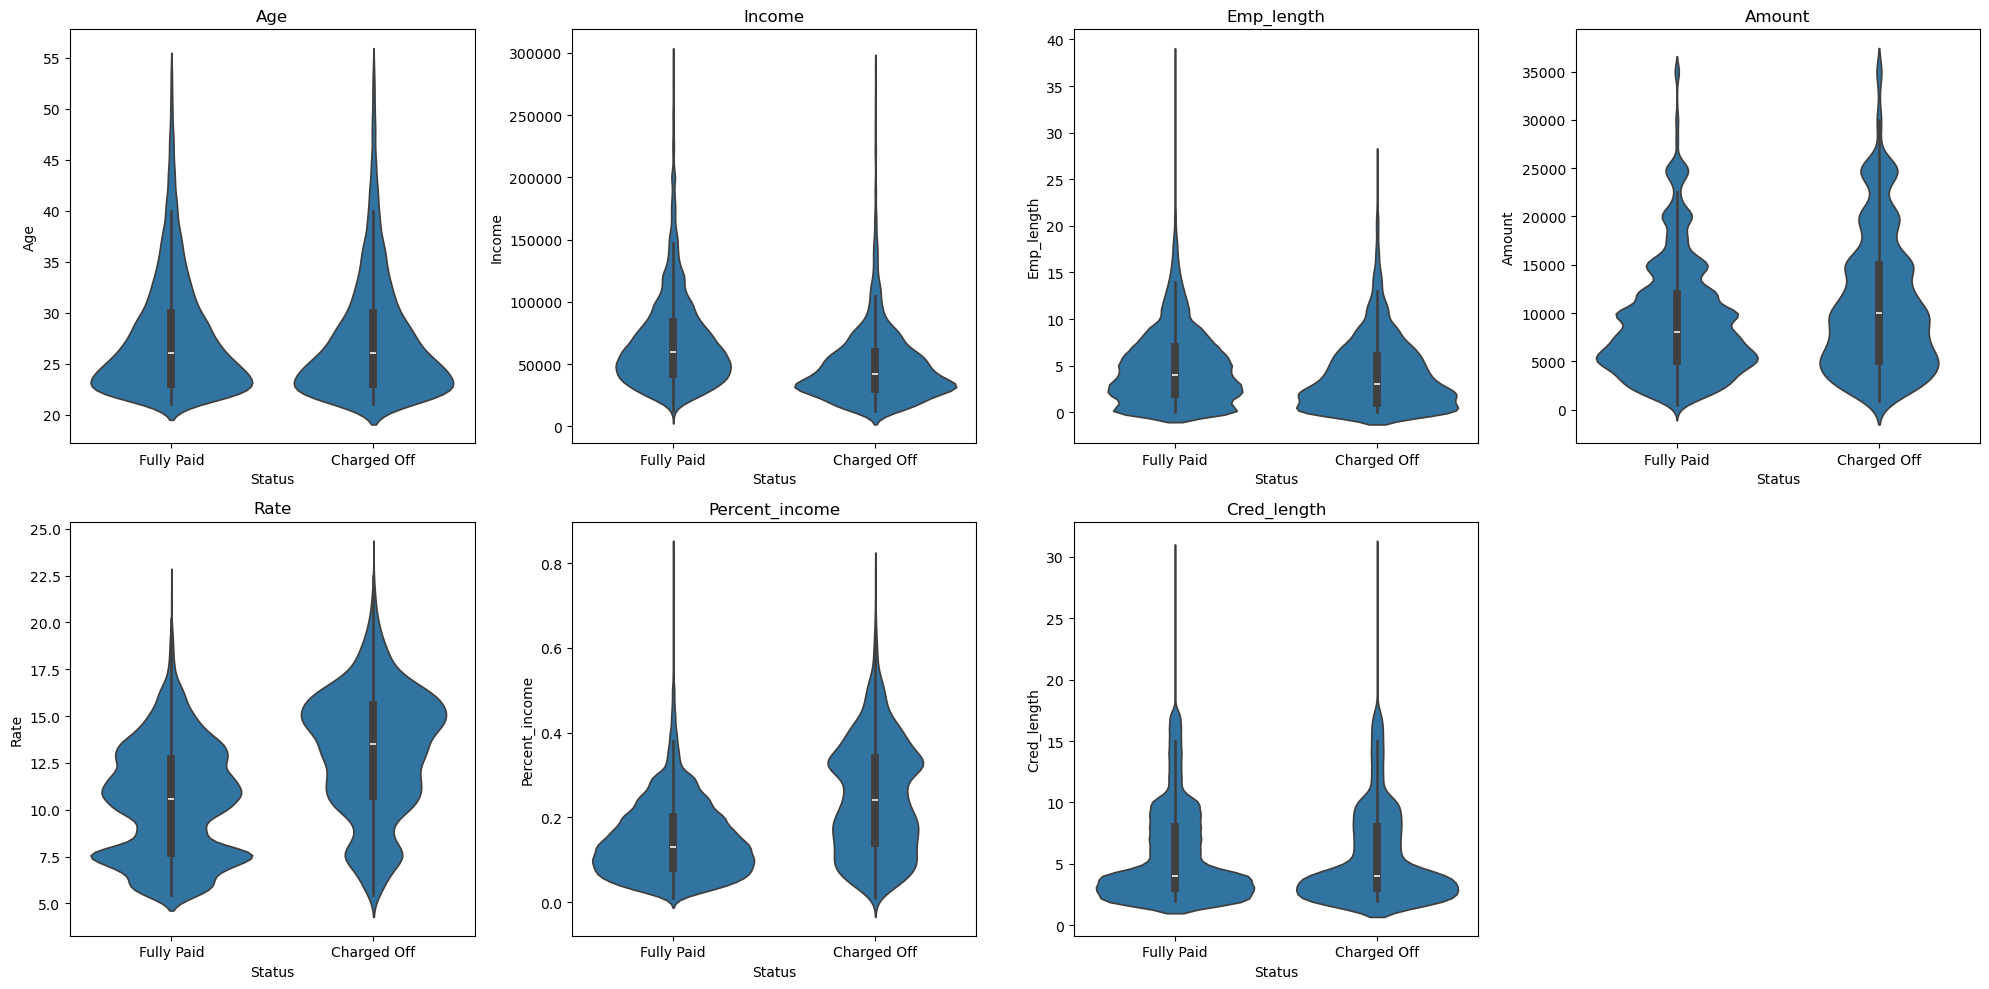

In [28]:
numeric_cols = ['Age', 'Income', 'Emp_length', 'Amount', 'Rate', 'Percent_income', 'Cred_length']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.violinplot(data=df_cleaned, x='Status', y=col, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('Status')
    axes[i].set_ylabel(col)
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Fully Paid', 'Charged Off'])

if len(numeric_cols) < len(axes):
    for j in range(len(numeric_cols), len(axes)):
        axes[j].set_visible(False)

plt.tight_layout()
plt.show()

**I then conducted a similar exploratory analysis for the categorical variables: *Home* (home type), *Intent* (purpose of the loan), and *Default* (previous defaults). The data showed that less than 8% of homeowners are likely to default. Conversely, this rate jumps to about one-third for applicants who do not own property and are renting. For clients with some equity in property, just over 10% still end up defaulting.**

**Examining defaults in relation to loan purpose revealed interesting insights. It turned out that loans for medical bills, home improvement, and debt consolidation have the highest default rates, with more than a quarter of borrowers in each segment unable to settle their debt. This is generally expected, as medical expenses and debt consolidation are often unavoidable costs that borrowers are required to cover regardless of their financial situation. In particular, borrowers taking loans for debt consolidation are often already under financial strain and have limited options to resolve their obligations. Medical loans may be taken by individuals who were previously in decent financial positions but might have been suddenly impacted by disruptive health conditions, affecting their cash flow. Additionally, many medical procedures require high upfront costs, and ongoing medical conditions may necessitate long-term monitoring and maintenance medication, further increasing the financial burden. Home improvement loans represent a discretionary expense that borrowers may perceive as necessary, but unlike other loan purposes, this spending rarely generates income. By contrast, loans for educational purposes or investment ventures have a higher likelihood of producing returns, especially in the long term. Personal loans, on the other hand, serve as a general-purpose category, allowing borrowers to use funds as they wish. Accordingly, this type of loan exhibited a higher default rate than educational or venture loans but remained lower than medical, home improvement, and debt consolidation loans.**

**Lastly, the correlation between previous loan defaults and current default risk is quite clear. More than one-third of borrowers with a history of default are at risk of defaulting again, whereas fewer than one-fifth of borrowers with no prior defaults default for the first time. While the distribution is uneven due to the larger proportion of clients without prior defaults, the trend is logical and aligns with expectations.**

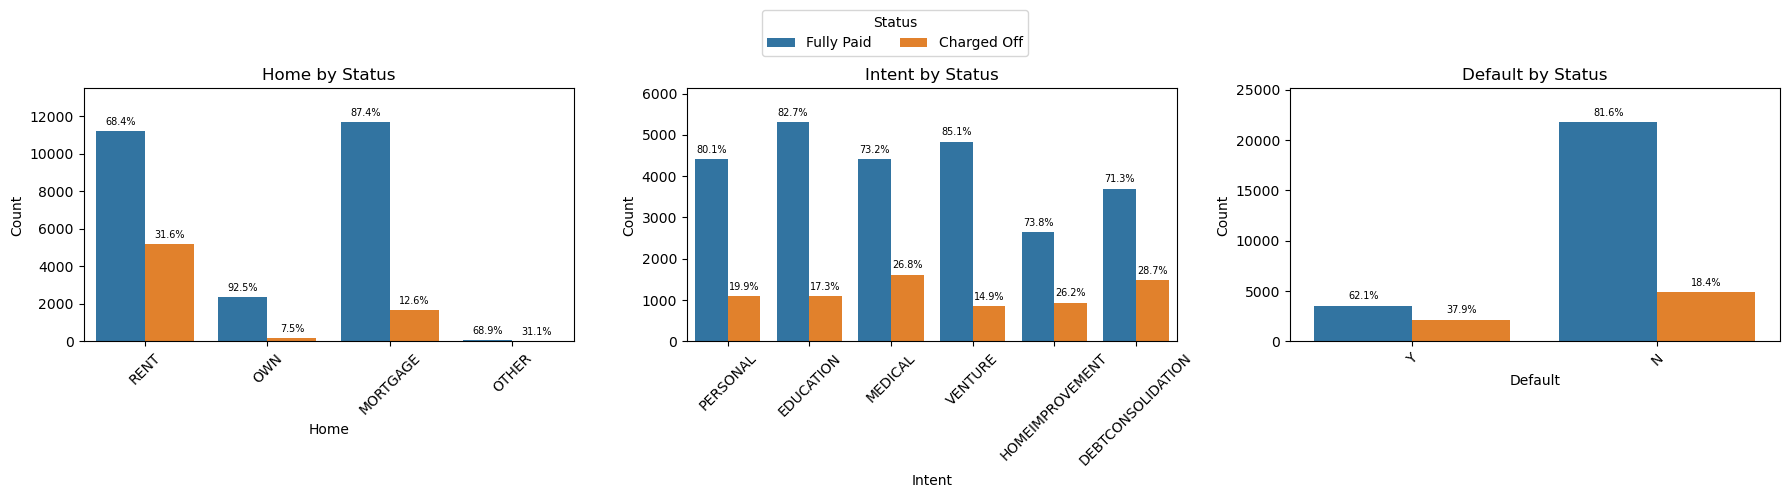

In [30]:
categorical_cols = ['Home', 'Intent', 'Default']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    sns.countplot(data=df_raw, x=col, hue='Status', ax=ax)
    ax.set_title(f'{col} by Status')
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.legend_.remove()

    total_per_cat = df_raw.groupby(col)['Status'].count()
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            x = p.get_x() + p.get_width() / 2.
            tick_labels = [t.get_text() for t in ax.get_xticklabels()]
            category_index = int(round(x))
            if category_index < len(tick_labels):
                cat_label = tick_labels[category_index]
                percent = height / total_per_cat[cat_label] * 100
                ax.annotate(f'{percent:.1f}%',
                            (x, height),
                            ha='center', va='bottom',
                            fontsize=7, color='black', xytext=(0, 3),
                            textcoords='offset points')
    ax.set_ylim(0, ax.get_ylim()[1] * 1.10)

handles, labels = axes[0].get_legend_handles_labels()
new_labels = ['Fully Paid' if label == '0' else 'Charged Off' for label in labels]
fig.legend(handles, new_labels, title='Status', loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1))
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()

**After exploring the distribution of numerical and categorical attributes relative to current default status, I then tried to find relationships between the different attributes. I began with the relationship between age and income, as this is relevant even outside the context of borrowing, with the intuitive assumption that income increases with age. While there is sound reasoning behind this association, simple linear regression analysis surprisingly revealed that income is much more evenly distributed across ages than what was typically expected. In fact, correlation analysis showed that there is no significant relationship between age and income in our dataset.**

**The hexbin plot further illustrated that most clients in the dataset were young earners in the \\$40,000–\\$60,000 range, but there was also a notable number of individuals in the same age range earning over \\$150,000. Conversely, the frequency of clients over 40 years old earning more than \$150,000 dropped sharply. It is important to highlight, however, that this cohort consists only of loan applicants and it may imply that older people with higher incomes are less likely to prefer, or even consider, borrowing money, regardless of the amount. Ultimately, the analysis showed that income may increase linearly with age but only up to a certain point, roughly around 25-26 years old, after which it plateaus.**

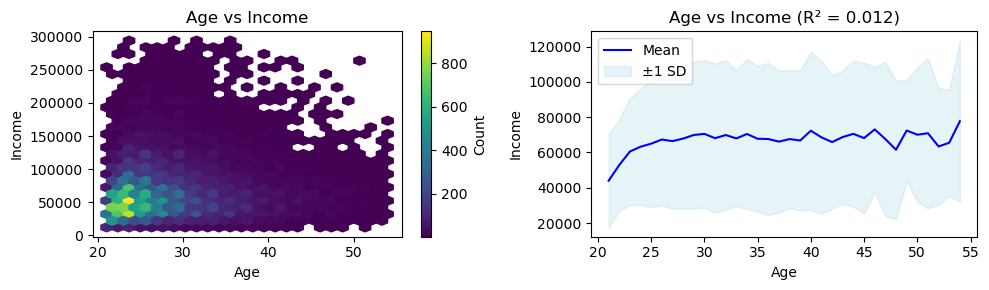

In [32]:
def plot_pair(ax_hex, ax_line, xvar, yvar, xlabel, ylabel, title_prefix):
    df_sub = df_cleaned[[xvar, yvar]].dropna()
    X = df_sub[[xvar]]
    y = df_sub[yvar]
    
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    stats = (df_sub.groupby(xvar)[yvar].agg(mean='mean', sd='std').reset_index())

    hb = ax_hex.hexbin(df_sub[xvar], df_sub[yvar], gridsize=25, cmap='viridis', mincnt=1)
    ax_hex.set_title(f'{title_prefix}')
    ax_hex.set_xlabel(xlabel)
    ax_hex.set_ylabel(ylabel)
    plt.colorbar(hb, ax=ax_hex, label='Count')

    ax_line.plot(stats[xvar], stats['mean'], color='blue', label='Mean')
    ax_line.fill_between(stats[xvar], stats['mean'] - stats['sd'], stats['mean'] + stats['sd'], color='lightblue', alpha=0.3, label='±1 SD')
    ax_line.set_title(f'{title_prefix} (R² = {r2:.3f})')
    ax_line.set_xlabel(xlabel)
    ax_line.set_ylabel(ylabel)
    ax_line.legend()

fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=False)
plot_pair(axes[0], axes[1], xvar='Age', yvar='Income', xlabel='Age', ylabel='Income', title_prefix='Age vs Income')
plt.tight_layout()
plt.show()

**I continued by examining the relationships between numerical attributes from the clients (i.e., age, income, employment length, and credit length) and attributes determined by the lender (i.e., interest rate and loan amount). The goal was to determine whether any of the client attributes were directly linked to, or at least influenced, the rate and amount granted to them. For interest rate, none of the individual client attributes showed any meaningful correlation. In fact, all resulted in correlation coefficients effectively equal to zero. The linear regression plots (except for income vs. rate) were also essentially flat, with volatility appearing toward the upper end of the x-axis. This volatility is likely due to a relatively small number of observations near and at the upper extreme, where few highly variable interest rate values disproportionately influence the average. This pattern was particularly noticeable in the employment length and credit length plots, where frequencies decreased sharply after around 18 years, leading to more pronounced fluctuations in the mean.**

**The income versus rate plot displayed a slightly different pattern, but the overall conclusion remained the same. Interest rates varied widely across all income levels, rising and falling erratically, while the overall trend remained flat. This was reflected in the negligible R² value from the correlation analysis. The hexbin plots further emphasized the skewed distribution of each attribute within a relatively narrow range, which was already previously discussed. At the same time, they also highlighted the broad spread of interest rates across all attribute values, reinforcing why the average trend lines remain flat across the full range.**


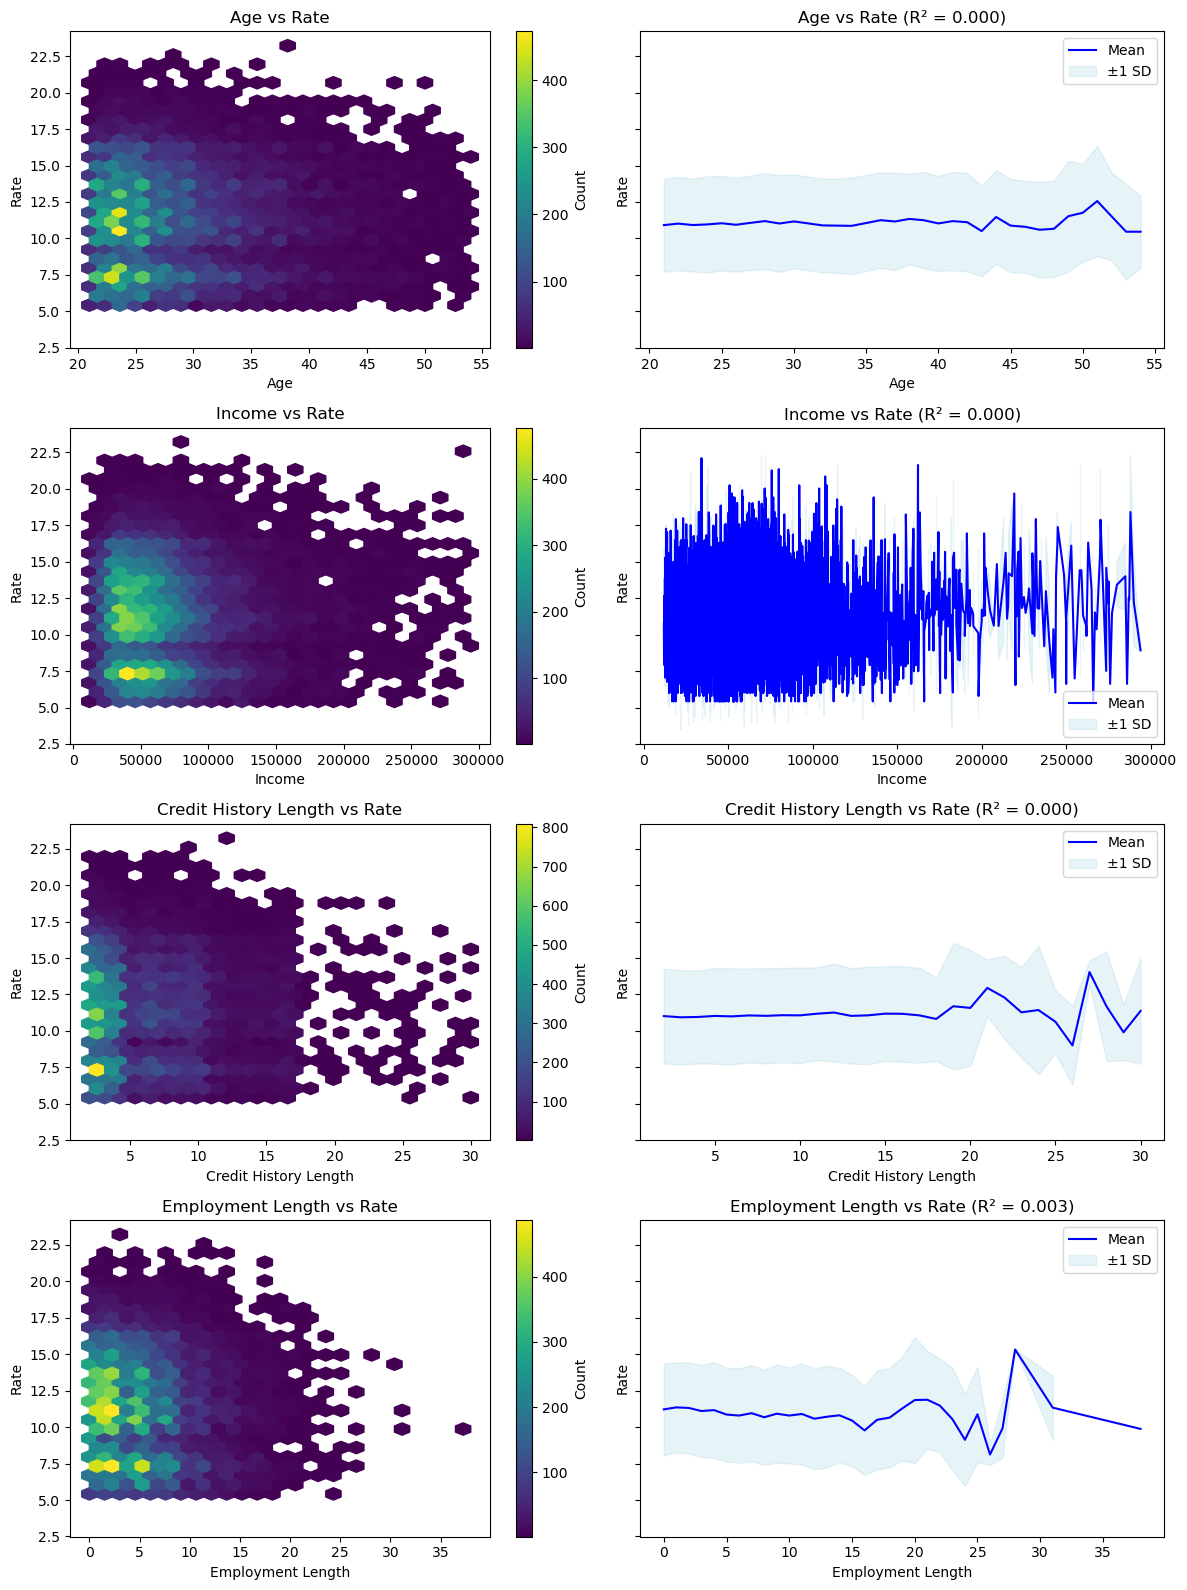

In [34]:
def plot_pair(ax_hex, ax_line, xvar, xlabel, title_prefix):
    df_sub = df_cleaned[[xvar, 'Rate']].dropna()
    X = df_sub[[xvar]]
    y = df_sub['Rate']

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    stats = (df_sub.groupby(xvar)['Rate'].agg(mean='mean', sd='std').reset_index())

    hb = ax_hex.hexbin(df_sub[xvar], df_sub['Rate'], gridsize=25, cmap='viridis', mincnt=1)
    ax_hex.set_title(f'{title_prefix} vs Rate')
    ax_hex.set_xlabel(xlabel)
    ax_hex.set_ylabel('Rate')
    plt.colorbar(hb, ax=ax_hex, label='Count')

    ax_line.plot(stats[xvar], stats['mean'], color='blue', label='Mean')
    ax_line.fill_between(stats[xvar], stats['mean'] - stats['sd'], stats['mean'] + stats['sd'], color='lightblue', alpha=0.3, label='±1 SD')
    ax_line.set_title(f'{title_prefix} vs Rate (R² = {r2:.3f})')
    ax_line.set_xlabel(xlabel)
    ax_line.set_ylabel('Rate')
    ax_line.legend()

fig, axes = plt.subplots(4, 2, figsize=(12, 16), sharey=True)
plot_pair(axes[0, 0], axes[0, 1], xvar='Age', xlabel='Age', title_prefix='Age')
plot_pair(axes[1, 0], axes[1, 1], xvar='Income', xlabel='Income', title_prefix='Income')
plot_pair(axes[2, 0], axes[2, 1], xvar='Cred_length', xlabel='Credit History Length', title_prefix='Credit History Length')
plot_pair(axes[3, 0], axes[3, 1], xvar='Emp_length', xlabel='Employment Length', title_prefix='Employment Length')
plt.tight_layout()
plt.show()

**For the relationship between client attributes and loan amount, the correlation coefficients were again effectively zero for age, employment length, and credit length. The wild swings in the mean line on the regression plots for these attributes can similarly be explained by the same reasoning applied to the interest rate plots. Indeed, we again observed a significant drop in the number of borrowers past year 18 for credit length and employment length. Additionally, the mean loan amount of roughly $10,000 remained consistent whether correlated with age, employment length, or credit length. For income versus loan amount, the analysis showed a weak correlation, with an R² value of 0.16. Although volatile spikes were again present in the plot, the overall trend exhibited a slight positive incline, explaining the weak correlation.**

**One striking observation is that some early 20-year-olds with little to no employment history or barely any credit history were granted the maximum loan amount of \\$35,000. Conversely, it was very rare for borrowers earning less than \\$50,000 to receive loans above \\$25,000, and none in this group were given the full $35,000. This insight suggests a difference in the significance of perceived or potential wealth (e.g., age, employment, credit history) compared to actual wealth (e.g., income) during credit risk assessments.**

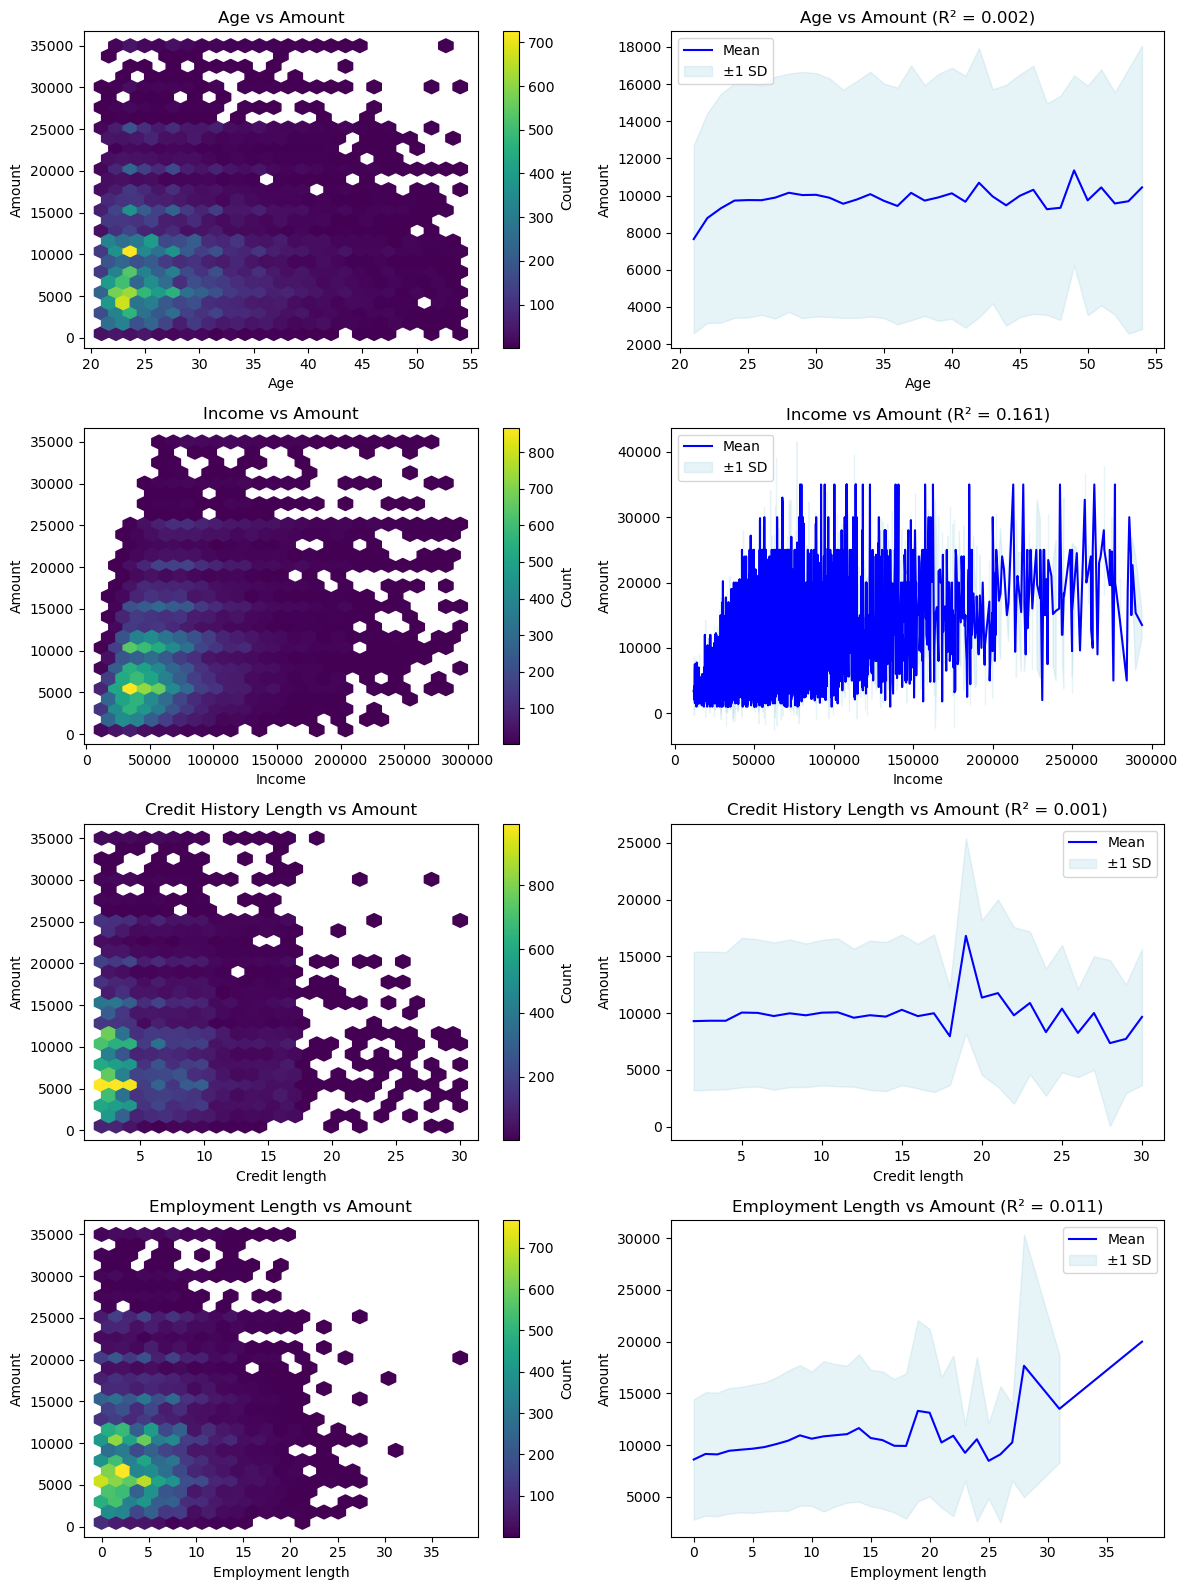

In [36]:
def plot_pair(ax_hex, ax_line, xvar, xlabel, title_prefix):
    df_sub = df_cleaned[[xvar, 'Amount']].dropna()
    X = df_sub[[xvar]]
    y = df_sub['Amount']

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    stats = (df_sub.groupby(xvar)['Amount'].agg(mean='mean', sd='std').reset_index())

    hb = ax_hex.hexbin(df_sub[xvar], df_sub['Amount'], gridsize=25, cmap='viridis', mincnt=1)
    ax_hex.set_title(f'{title_prefix} vs Amount')
    ax_hex.set_xlabel(xlabel)
    ax_hex.set_ylabel('Amount')
    plt.colorbar(hb, ax=ax_hex, label='Count')

    ax_line.plot(stats[xvar], stats['mean'], color='blue', label='Mean')
    ax_line.fill_between(stats[xvar], stats['mean'] - stats['sd'], stats['mean'] + stats['sd'], color='lightblue', alpha=0.3, label='±1 SD')
    ax_line.set_title(f'{title_prefix} vs Amount (R² = {r2:.3f})')
    ax_line.set_xlabel(xlabel)
    ax_line.set_ylabel('Amount')
    ax_line.legend()

fig, axes = plt.subplots(4, 2, figsize=(12, 16), sharey=False)
plot_pair(axes[0,0], axes[0,1], xvar='Age', xlabel='Age', title_prefix='Age')
plot_pair(axes[1,0], axes[1,1], xvar='Income', xlabel='Income', title_prefix='Income')
plot_pair(axes[2,0], axes[2,1], xvar='Cred_length', xlabel='Credit length', title_prefix='Credit History Length')
plot_pair(axes[3,0], axes[3,1], xvar='Emp_length', xlabel='Employment length', title_prefix='Employment Length')
plt.tight_layout()
plt.show()

# **MODEL BUILDING, TUNING, AND EVALUATION**

**Since no individual client attribute showed a clear linear relationship with *Rate* or *Amount*, I explored whether incorporating all numerical client attributes into a linear regression model would yield better results. I also applied Ridge and Lasso regression to assess whether regularization could improve model performance. However, the results still confirmed that no meaningful linear relationship exists, even when these attributes are taken together.**

In [39]:
target = 'Rate'   # or 'Amount'
predictors = ['Age', 'Income', 'Cred_length', 'Emp_length'] 
df_model = df_cleaned[[target] + predictors].dropna()
X = df_model[predictors]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlr = LinearRegression()
ridge_alphas = np.logspace(-3, 3, 50)
ridge = RidgeCV(alphas=ridge_alphas, cv=5)
lasso_alphas = np.logspace(-3, 1, 50)
lasso = LassoCV(alphas=lasso_alphas, max_iter=10000, cv=5, random_state=42)

results = []
def eval_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return name, r2, rmse, model

for name, model in [('MLR', mlr), ('Ridge', ridge), ('Lasso', lasso)]:
    results.append(eval_model(name, model))

results_df = pd.DataFrame([(name, r2, rmse) for name, r2, rmse, _ in results], columns=['Model', 'R²', 'RMSE']).sort_values(by='R²', ascending=False)
print("\nModel Performance Comparison:")
print(results_df)

lasso_model = [m for n, _, _, m in results if n == 'Lasso'][0]
lasso_coefs = pd.Series(lasso_model.coef_, index=predictors)

print("\nLasso Selected Features (non-zero coefficients):")
print(lasso_coefs[lasso_coefs != 0])
print("\nLasso Dropped Features:")
print(lasso_coefs[lasso_coefs == 0])


Model Performance Comparison:
   Model        R²      RMSE
0    MLR  0.007078  3.225543
1  Ridge  0.007067  3.225561
2  Lasso  0.006917  3.225804

Lasso Selected Features (non-zero coefficients):
Age            5.702266e-04
Income         1.072587e-07
Cred_length    1.324257e-02
Emp_length    -4.455249e-02
dtype: float64

Lasso Dropped Features:
Series([], dtype: float64)


**I repeated the analysis, this time incorporating both numerical and categorical attributes. The results showed an improved, yet still weak, linear relationship between the interest rate and the collective set of variables. Notably, a client’s previous default status (*Default*) stood out as the most influential factor. Holding all other factors constant, having a prior default was associated with an average increase of 4.15 percentage points in the interest rate. This difference could significantly raise the risk for a subsequent default. An example would be a jump from 12%, a rate received by about 70% of clients who eventually settled their loan, to 16%, a rate very frequently received by those who eventually defaulted.**

**Applying the same modeling approach to *Amount*, we again observed a slight improvement in the predictive signal when all variables were included. However, the overall relationship remained conclusively weak. Similar to *Rate*, previous default status exhibited the strongest association with the loan amount when all other factors are held constant. Curiously though, the Lasso regression results indicated that a previous default was associated with an INCREASE in a succeeding given loan amount by an average of approximately \\$580. Given an average loan amount of around \\$10,000 (as observed in earlier regression plots), this represents roughly a 6% increase. Moreover, if the baseline amount was closer to \$5,000, as suggested by the mode, the increase would exceed 10%.**

**This counterintuitive result may reflect more about borrower behavior than lender decision-making. Clients with a history of default may demonstrate a more pressing need, along with a higher risk tolerance, by requesting for larger loan amounts in subsequent applications. Thus, borrowing more, especially relative to income, could be a behavioral marker of riskier client profiles.**

In [41]:
target = 'Rate'
drop_cols = ['Status', 'Amount', 'Percent_income', 'Home_OTHER', 'Intent_PERSONAL']
predictors = [c for c in df_encoded.columns if c not in drop_cols + [target]]
df_model = df_cleaned[[target] + predictors].dropna()
X = df_model[predictors]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlr = LinearRegression()
ridge_alphas = np.logspace(-2, 3, 50)
ridge = make_pipeline(StandardScaler(), RidgeCV(alphas=ridge_alphas, cv=5))
lasso_alphas = np.logspace(-3, 1, 50)
lasso_std_pipe = make_pipeline(StandardScaler(), LassoCV(alphas=lasso_alphas, max_iter=10000, cv=5, random_state=42))
lasso_raw = LassoCV(alphas=lasso_alphas, max_iter=10000, cv=5, random_state=42)

results = []
for name, model in [('MLR', mlr), ('Ridge', ridge), ('Lasso', lasso_std_pipe)]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append((name, r2, rmse))

lasso_raw.fit(X_train, y_train)

results_df = pd.DataFrame(results, columns=['Model', 'R²', 'RMSE']).sort_values(by='R²', ascending=False)
print("\nModel Performance Comparison (Rate target):")
print(results_df)

coefs_std = pd.Series(lasso_std_pipe.named_steps['lassocv'].coef_, index=predictors)
coefs_raw = pd.Series(lasso_raw.coef_, index=predictors)
coef_compare = pd.DataFrame({'Standardized_Coefficient': coefs_std,'Target_Units': coefs_raw})
coef_compare = coef_compare[(coef_compare != 0).any(axis=1)]
coef_compare = coef_compare.reindex(coef_compare['Target_Units'].abs().sort_values(ascending=False).index)

print("\nLasso Coefficients:")
print(coef_compare)


Model Performance Comparison (Rate target):
   Model        R²      RMSE
0    MLR  0.266086  2.773115
1  Ridge  0.266067  2.773150
2  Lasso  0.265944  2.773384

Lasso Coefficients:
                          Standardized_Coefficient  Target_Units
Default                                   1.584385      4.151193
Home_MORTGAGE                            -0.373117     -0.713776
Home_OWN                                 -0.110904     -0.368042
Intent_HOMEIMPROVEMENT                    0.031604      0.098392
Home_RENT                                 0.000000      0.045459
Intent_VENTURE                           -0.013627     -0.036824
Intent_DEBTCONSOLIDATION                 -0.013498     -0.036745
Intent_EDUCATION                         -0.014085     -0.036344
Emp_length                               -0.063330     -0.016527
Cred_length                               0.030133      0.010884
Intent_MEDICAL                            0.003785      0.009396
Age                                   

In [42]:
target = 'Amount'
drop_cols = ['Status', 'Rate', 'Percent_income', 'Home_OTHER', 'Intent_PERSONAL']
predictors = [c for c in df_encoded.columns if c not in drop_cols + [target]]
df_model = df_cleaned[[target] + predictors].dropna()
X = df_model[predictors]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlr = LinearRegression()
ridge_alphas = np.logspace(-2, 3, 50)
ridge = make_pipeline(StandardScaler(), RidgeCV(alphas=ridge_alphas, cv=5))
lasso_alphas = np.logspace(-3, 1, 50)
lasso_std_pipe = make_pipeline(StandardScaler(), LassoCV(alphas=lasso_alphas, max_iter=10000, cv=5, random_state=42))
lasso_raw = LassoCV(alphas=lasso_alphas, max_iter=10000, cv=5, random_state=42)

results = []
for name, model in [('MLR', mlr), ('Ridge', ridge), ('Lasso', lasso_std_pipe)]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append((name, r2, rmse))

lasso_raw.fit(X_train, y_train)

results_df = pd.DataFrame(results, columns=['Model', 'R²', 'RMSE']).sort_values(by='R²', ascending=False)
print("\nModel Performance Comparison (Amount target):")
print(results_df)

coefs_std = pd.Series(lasso_std_pipe.named_steps['lassocv'].coef_, index=predictors)
coefs_raw = pd.Series(lasso_raw.coef_, index=predictors)
coef_compare = pd.DataFrame({'Standardized_Coefficient': coefs_std,'Target_Units': coefs_raw})
coef_compare = coef_compare[(coef_compare != 0).any(axis=1)]
coef_compare = coef_compare.reindex(coef_compare['Target_Units'].abs().sort_values(ascending=False).index)

print("\nLasso Coefficients:")
print(coef_compare)


Model Performance Comparison (Amount target):
   Model        R²         RMSE
1  Ridge  0.153292  5765.975005
0    MLR  0.153285  5766.000203
2  Lasso  0.153148  5766.467258

Lasso Coefficients:
                          Standardized_Coefficient  Target_Units
Default                                 238.067895    583.847985
Intent_HOMEIMPROVEMENT                   74.009592    164.927727
Emp_length                              198.545276     51.566719
Age                                     -41.061691     -8.673137
Income                                 2491.604808      0.067948
Home_RENT                                -1.127835     -0.000000
Intent_DEBTCONSOLIDATION                  6.593020      0.000000
Intent_VENTURE                           -4.982458     -0.000000


**Since we have established that the relationship between client attributes and loan attributes is non-linear, I proceeded to explore non-linear interactions to gain further insight and improve predictive performance. To do this, I applied the Random Forest algorithm using an 80-20 train-test split with automated hyperparameter tuning. For this analysis and all subsequent Random Forest runs, I tested 30 randomly selected combinations of tree parameters and used a 5-fold cross-validation for model evaluation. For the predictors, I excluded *Amount* and *Status* (as they are not client attributes), as well as *Percent_income* (since it is derived from *Amount*).**

**The results showed marginal improvement in R² compared to the linear models, suggesting that other factors (e.g. credit scores) which are not included in our dataset likely play a more significant role in determining the interest rate offered to a client. Among the available predictors, the Random Forest analysis confirmed that previous default status is a key factor in rate determination, reinforcing the findings from the linear models. Interestingly, loan purpose appeared to have minimal impact on predicting interest rates.**

Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}

Performance (Rate):
  R²:   0.286
  RMSE: 2.721


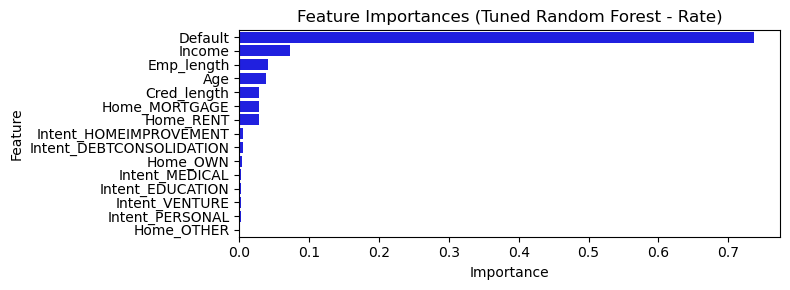

In [44]:
# RANDOM FOREST RATE TARGET
df_rf_rate = df_encoded.copy()
target = 'Rate'
drop_cols = ['Status', 'Amount', 'Percent_income']
predictors = [c for c in df_rf_rate.columns if c not in drop_cols + [target]]
df_model = df_rf_rate[[target] + predictors].dropna()
X = df_model[predictors]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 10, 50],
    'max_features': ['sqrt', 'log2']}

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=1,
    verbose=0)
random_search.fit(X_train, y_train)
rf_best = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

y_pred = rf_best.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("\nPerformance (Rate):")
print(f"  R²:   {r2:.3f}")
print(f"  RMSE: {rmse:.3f}")

importances = pd.Series(rf_best.feature_importances_, index=predictors).sort_values(ascending=False)

plt.figure(figsize=(8, len(importances) * 0.2)) 
sns.barplot(x=importances.values, y=importances.index, color='blue')
plt.title('Feature Importances (Tuned Random Forest - Rate)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

**The same workflow was applied to *Amount*, and similar to *Rate*, the ensemble model resulted to a very minimal improvement in R² value. Additionally, *Income* emerged as the most important feature in the analysis, consistent with the linear regression results where Lasso analysis identified *Income* as having the highest standardized coefficient among the variables. Likewise, loan purpose continued to exhibit virtually no predictive power for loan amount.**

Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}

Performance (Amount):
  R²:   0.174
  RMSE: 5730.664


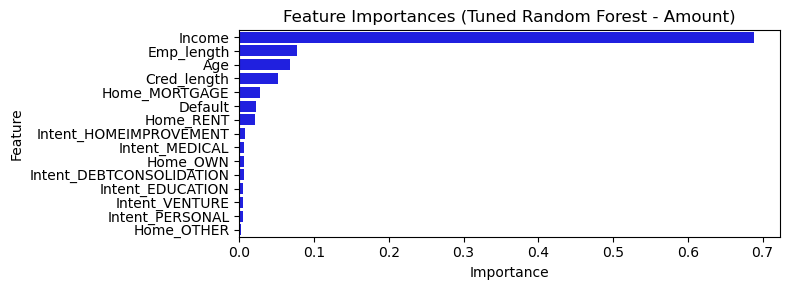

In [46]:
# RANDOM FOREST AMOUNT TARGET
df_rf_amount = df_encoded.copy()
target = 'Amount'
drop_cols = ['Status', 'Rate', 'Percent_income']
predictors = [c for c in df_rf_amount.columns if c not in drop_cols + [target]]
df_model = df_rf_amount[[target] + predictors].dropna()
X = df_model[predictors]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 10, 50],
    'max_features': ['sqrt', 'log2']}

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=1,
    verbose=0)
random_search.fit(X_train, y_train)
rf_best = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

y_pred = rf_best.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("\nPerformance (Amount):")
print(f"  R²:   {r2:.3f}")
print(f"  RMSE: {rmse:.3f}")

importances = pd.Series(rf_best.feature_importances_, index=predictors).sort_values(ascending=False)

plt.figure(figsize=(8, len(importances) * 0.2)) 
sns.barplot(x=importances.values, y=importances.index, color='blue')
plt.title('Feature Importances (Tuned Random Forest - Amount)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

**We have now established, through both linear and non-linear models, that there are likely other more important factors that determine the interest rate and loan amount. I then turned to assessing how well our dataset can predict whether a borrower will fully repay or default on a current loan. To do this, I applied the same machine learning model with a different target variable: *Status*. The train-test split, hyperparameter tuning, and cross-validation settings remained the same. However, the scoring metric was set to optimize the balance between false positives and false negatives using the F1 score. I also incorporated class weight tuning to reduce statistical bias, since good payers are three times more common than defaulters in the dataset.**

**For the initial run, I used all available attributes as features to establish a baseline. The baseline model already showed good overall accuracy and performed exceptionally well at identifying good payers (*Precision* and *Recall* for Class 0), even when class weights were adjusted at a 1:5 ratio to emphasize defaulters. The model likewise exhibited high *Precision* for Class 1 (defaulters), with a score of 0.91, indicating high accuracy in predicting defaulters and rarely misclassifying good payers as otherwise. In addition, it also demonstrated strong ranking ability, correctly distinguishing likely defaulters about 93% of the time as indicated by the ROC curve.** 

**Despite these strengths, the model fell a bit short in identifying all actual defaulters, tagging some of them as low-risk. At the current classification cutoff, a *Recall* of 0.70 for Class 1 means it only catches 70% of actual defaulters. Put differently, it wrongly classifies 3 out of every 10 true defaulters as good payers. This type of error could be costly, as the lender may offer these applicants with terms intended for low-risk borrowers, only to have their loans eventually charged off. In terms of feature importance, the model identified interest rate and loan amount-to-income ratio (*Percent_income*) as the strongest predictors of default. This aligns with earlier violin plot visuals that showed clear distributional differences between payers and defaulters in these variables. Unsurprisingly, income and loan amount, the two variables from which *Percent_income* was derived, were the next most important features.**

**While these initial results already seemed fairly robust, I wanted to further tune the model to better identify defaulters, as they represent the primary source of financial loss for lenders. Misclassifying a good payer as a defaulter may result in lost revenue opportunities due to declined applications, but it does not cause direct cash loss. In contrast, failing to correctly identify a defaulter results in direct financial losses due to charged-off loans.**

Best Hyperparameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'class_weight': {0: 1, 1: 5}}

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5066
           1       0.91      0.70      0.79      1418

    accuracy                           0.92      6484
   macro avg       0.92      0.84      0.87      6484
weighted avg       0.92      0.92      0.92      6484



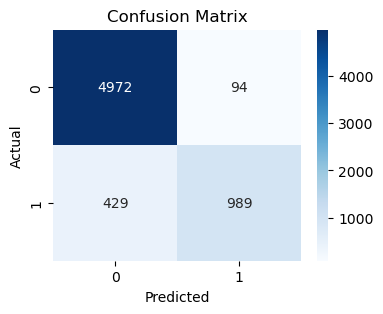

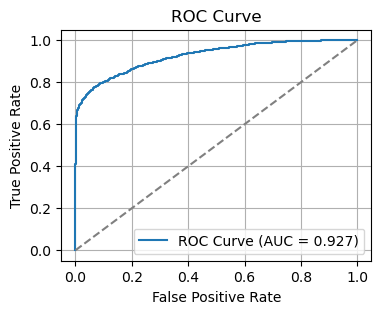

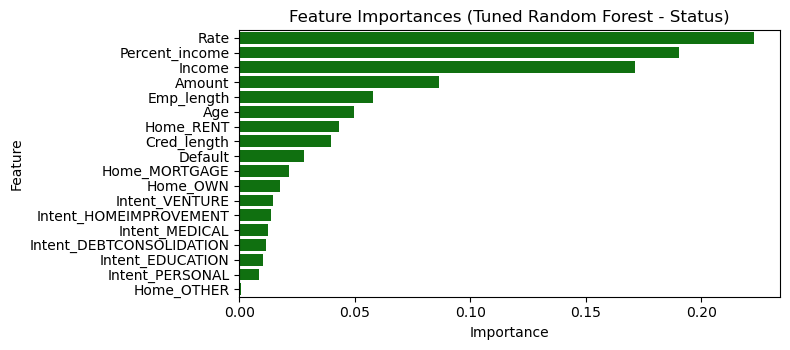

In [48]:
# RANDOM FOREST STATUS TARGET - ALL COLUMNS AS FEATURES
df_rf_status = df_encoded.copy()
target = 'Status'
predictors = [c for c in df_rf_status.columns if c != target]
X = df_rf_status[predictors]
y = df_rf_status[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 50],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced', {0: 1, 1: 3}, {0: 1, 1: 5}]}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=0)
random_search.fit(X_train, y_train)
best_rf_all = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

y_pred = best_rf_all.predict(X_test)
y_pred_proba = best_rf_all.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

importances = pd.Series(best_rf_all.feature_importances_, index=predictors).sort_values(ascending=False)

plt.figure(figsize=(8, len(importances) * 0.2)) 
sns.barplot(x=importances.values, y=importances.index, color='green')
plt.title('Feature Importances (Tuned Random Forest - Status)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

**To improve the initial model, I began with feature engineering to identify which features could be introduced to promote more aggressive identification of defaulters. Since *Rate* and *Percent_income* were determined to be the most important features, I generated new binned features from them. Specifically, I binned *Percent_income* into four categories (0.2, 0.4, 0.6, 1) and grouped *Rate* into bins with 2.5% intervals. The idea was that clustering these continuous variables might enhance their predictive power.**

**I ran experiments using *Rate* and *Percent_income* both as continuous variables and as binned features. However, the results were essentially the same. *Rate* remained as the most important feature, whether continuous or binned, while *Percent_income* lost some predictive power after binning. This could be because binning decoupled *Percent_income* from its original components, *Amount* and *Income*, both of which superseded the former in the feature importance ranking. In terms of model performance, *Recall* improved marginally by 0.01, but at the cost of *Precision*, which dropped by 0.05. This suggests that while binning very slightly improved the model's ability to identify some defaulters, it otherwise caused the model to flag more good payers as defaulters (i.e., more false positives).**

Best Hyperparameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'class_weight': {0: 1, 1: 5}}

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      5066
           1       0.86      0.71      0.78      1418

    accuracy                           0.91      6484
   macro avg       0.89      0.84      0.86      6484
weighted avg       0.91      0.91      0.91      6484



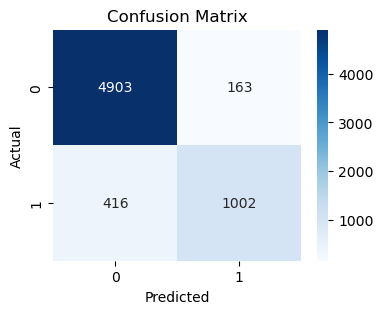

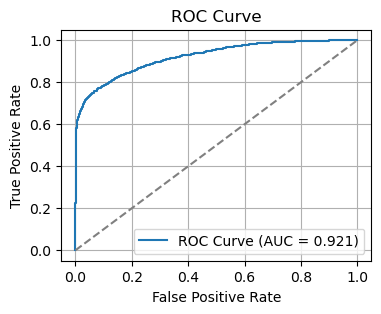

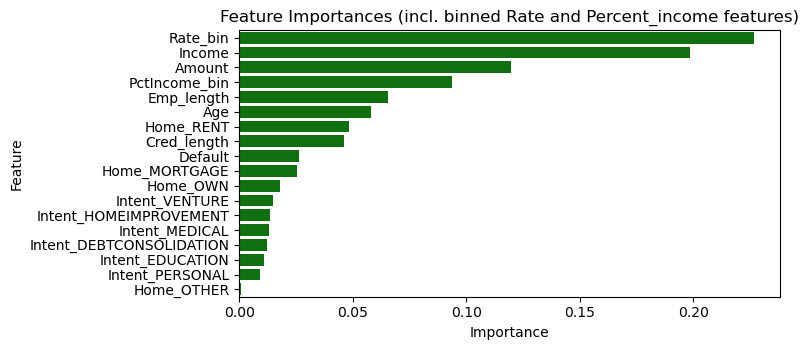

In [50]:
# RANDOM FOREST STATUS TARGET - BINNED PERCENT INCOME AND RATE GENERATED FEATURES
df_work = df_encoded.copy()

# Generate binned Percent_income feature
def bin_percent_income(val):
    if val <= 0.2:
        return 1
    elif val <= 0.4:
        return 2
    elif val <= 0.6:
        return 3
    else:
        return 4

df_work['PctIncome_bin'] = df_work['Percent_income'].apply(bin_percent_income)

# Generate binned Rate feature
bin_width = 0.025
max_rate = df_work['Rate'].max()
bins = np.arange(0, max_rate + bin_width, bin_width)
df_work['Rate_bin'] = pd.cut(df_work['Rate'], bins=bins, labels=False, include_lowest=True)
df_work = df_work.drop(columns=['Percent_income', 'Rate'])

target = 'Status'
predictors = [c for c in df_work.columns if c != target]
X = df_work[predictors]
y = df_work[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 50],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced', {0: 1, 1: 3}, {0: 1, 1: 5}]}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=0)
random_search.fit(X_train, y_train)
best_rf_binned = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

y_pred = best_rf_binned.predict(X_test)
y_pred_proba = best_rf_binned.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

importances = pd.Series(best_rf_binned.feature_importances_, index=predictors).sort_values(ascending=False)

plt.figure(figsize=(8, len(importances) * 0.2)) 
sns.barplot(x=importances.values, y=importances.index, color='green')
plt.title('Feature Importances (incl. binned Rate and Percent_income features)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

**I then had to think of an asymmetric feature, one that is not easily derived from the available features. I determined that the best way to do this was to combine a numerical attribute with a categorical one. For the numerical attribute, I considered only *Rate* and *Percent_income*, as both had been shown visually and statistically to be associated with the risk of default. However, since I had previously observed that the predictive power of *Rate* remained unchanged even after feature generation, I decided to proceed with *Percent_income*.**

**For the categorical attribute, my choices were home type (*Home*), loan purpose (*Intent*), and previous default status (*Default*). It has been demonstrated repeatedly that loan purpose and, in some cases, home type do not significantly influence loan terms such as loan amount and interest rate, nor are they strongly associated with a client’s current default status (*Status*). In addition, creating interaction features between *Percent_income* and either home type or loan purpose would result in a large number of subcategories, which in turn would increase computational cost. Therefore, I chose previous default status, which is binary and more efficient to work with. Before including this feature in model training, I first explored how the interaction would look like. I binned *Percent_income* and associated each bin with either *Default* = 0 (no previous default) or *Default* = 1 (previously defaulted). I then totaled the number of cases in each sub-bin and calculated the current default rate for each combination.**

**The results clearly showed that clients with a history of default had a significantly higher current default rate given the same *Percent_income* level. For instance, only about 1 out of 10 clients with a quite manageable loan-to-income ratio of 0.20 and no previous defaults failed to settle their current obligations. However, this rate nearly triples among clients with the same loan-to-income ratio but with a history of default. Moreover, across all *Percent_income* bins, the current default rate for clients without prior defaults never exceeded 75%. In contrast, more than 8 out of 10 clients with previous defaults who borrowed an amount greater than 40% of their income ended up defaulting on their current loan.**

**In summary, these figures collectively demonstrate that the impact of repayment burden, as measured by *Percent_income*, is amplified for individuals who have had prior defaults. Applicants with a high loan-to-income ratio already signal elevated credit risk, and that risk becomes substantially greater if the borrower also has a history of default. This supports the idea that financial strain and behavioral risk interact, and I hoped that capturing this interaction would help the model better differentiate between temporary financial stress and a consistent pattern of non-repayment.**

In [52]:
# DEFAULT x BINNED PERCENT INCOME GENERATED FEATURE

df_interaction = df_encoded.copy()

def bin_percent_income(x):
    if x <= 0.2:
        return 1
    elif x <= 0.4:
        return 2
    elif x <= 0.6:
        return 3
    else:
        return 4

df_interaction['PercentIncome_bin'] = df_interaction['Percent_income'].apply(bin_percent_income)
df_interaction['Default_x_PctIncomeBin'] = df_interaction['Default'].astype(str) + '_' + df_interaction['PercentIncome_bin'].astype(str)
summary_df = df_interaction.groupby(['PercentIncome_bin', 'Default']).agg(Bin_Total=('Status', 'count'), 
                                                                      Bin_Current_Defaults=('Status', lambda x: (x == 1).sum())).reset_index()
summary_df['Current_Default_Rate'] = (summary_df['Bin_Current_Defaults'] / summary_df['Bin_Total'] * 100).round(2)
summary_df = summary_df.sort_values(['Default', 'PercentIncome_bin'])
summary_df

,PercentIncome_bin,Default,Bin_Total,Bin_Current_Defaults,Current_Default_Rate
0,1,0,18694,1962,10.50
2,2,0,7105,2321,32.67
4,3,0,848,607,71.58
6,4,0,39,29,74.36
1,1,1,3735,1079,28.89
3,2,1,1763,897,50.88
5,3,1,221,184,83.26
7,4,1,11,10,90.91


Best Hyperparameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'class_weight': {0: 1, 1: 5}}

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      5066
           1       0.87      0.71      0.78      1418

    accuracy                           0.91      6484
   macro avg       0.90      0.84      0.86      6484
weighted avg       0.91      0.91      0.91      6484



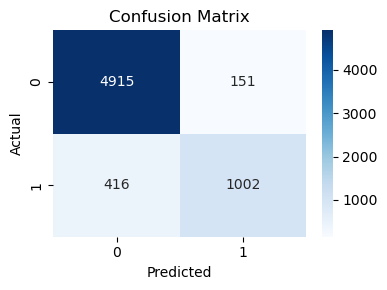

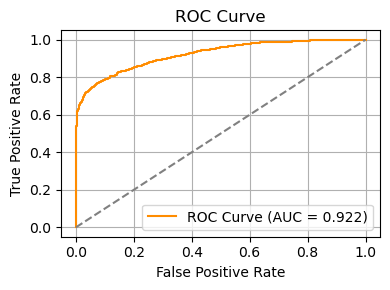

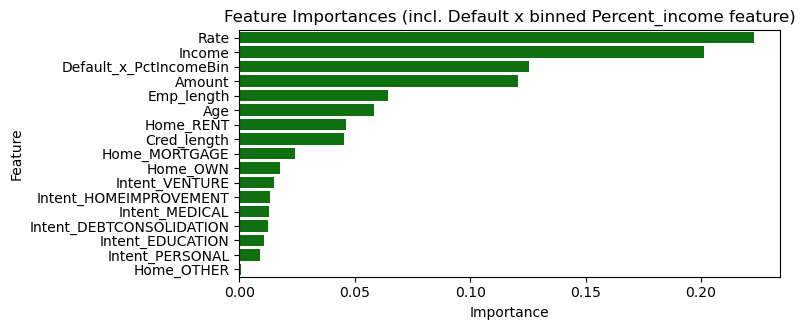

In [53]:
# RANDOM FOREST STATUS TARGET - DEFAULT x BINNED PERCENT INCOME GENERATED FEATURE
df_rf = df_encoded.copy()

def bin_percent_income(x):
    if x <= 0.2:
        return 1
    elif x <= 0.4:
        return 2
    elif x <= 0.6:
        return 3
    else:
        return 4

df_rf['PctIncome_bin'] = df_rf['Percent_income'].apply(bin_percent_income)
df_rf['Default_x_PctIncomeBin'] = df_rf['Default'] * 10 + df_rf['PctIncome_bin']
target = 'Status'
#predictors = [col for col in df_rf.columns if col != target]
drop_cols = ['Default', 'Percent_income', 'PctIncome_bin']
predictors = [col for col in df_rf.columns if col not in drop_cols + [target]]
X = df_rf[predictors]
y = df_rf[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 50],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced', {0: 1, 1: 3}, {0: 1, 1: 5}]}

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=0)
random_search.fit(X_train, y_train)
best_rf_defxbinnedpi = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

y_pred = best_rf_defxbinnedpi.predict(X_test)
y_proba = best_rf_defxbinnedpi.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})', color='darkorange')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

importances = pd.Series(best_rf_defxbinnedpi.feature_importances_, index=predictors).sort_values(ascending=False)

plt.figure(figsize=(8, len(importances) * 0.2)) 
sns.barplot(x=importances.values, y=importances.index, color='green')
plt.title("Feature Importances (incl. Default x binned Percent_income feature)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

**Ironically, despite the intuitive results we observed from the generated *Default*-binned *Percent_income* interaction, the output of the Random Forest model was virtually identical to the previous iteration. Model performance, ROC curve, and feature importance rankings were practically unchanged. I then pivoted to generating the same interaction feature, but this time using the raw *Percent_income* values instead of binned categories. Once again, model performance remained the same. This suggests that the Random Forest algorithm was able to infer the underlying relationships in the data regardless of whether stratification was applied. In other words, the model could "see through" the binning and arrive at the same associations.**

**One thing that stood out, however, was that despite identical performance metrics, the importance of the generated interaction feature diminished substantially. Upon closer inspection, I realized that the way the feature was constructed had effectively flattened all *Percent_income* values for clients with no previous defaults to zero. This occurred because the binary value for no previous defaults was zero, thereby nullifying any value it was multiplied with. To address this, I ran a subsequent experiment using the same concept but with a different approach to feature generation. In this version, any *Percent_income* value from clients with no previous defaults was converted to a negative number. This retained the distinct *Percent_income* values while signaling to the algorithm that the client has not previously defaulted. I referred to this technique as creating a "signed" feature.**

**Using this approach, *Precision* for Class 1 (defaulters) improved from 0.87 to 0.92. Yet, *Recall* for the same class remained at a modest 0.70, resulting in an F1 score of 0.79, which is practically the same as in all previous iterations of the experiment. Interestingly, the importance score of the newly generated feature increased nearly fourfold, making it the second most important feature after *Rate*. This suggests that creating similar interactions between numerical and categorical variables could enhance a feature's predictive signal. In our case, however, it appeared we had already maximized the value that could be obtained from feature engineering. It seemed best to shift focus toward tuning other aspects of the model.**

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'class_weight': {0: 1, 1: 3}}

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      5066
           1       0.87      0.71      0.78      1418

    accuracy                           0.91      6484
   macro avg       0.89      0.84      0.86      6484
weighted avg       0.91      0.91      0.91      6484



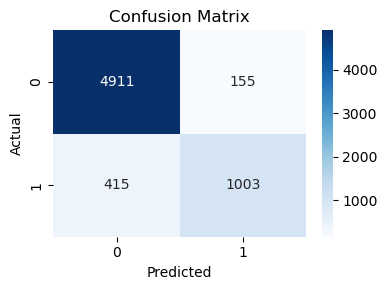

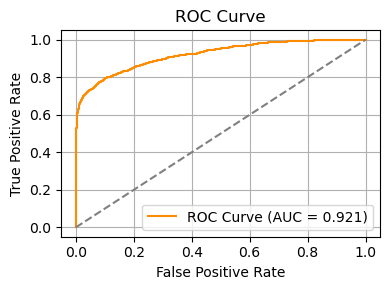

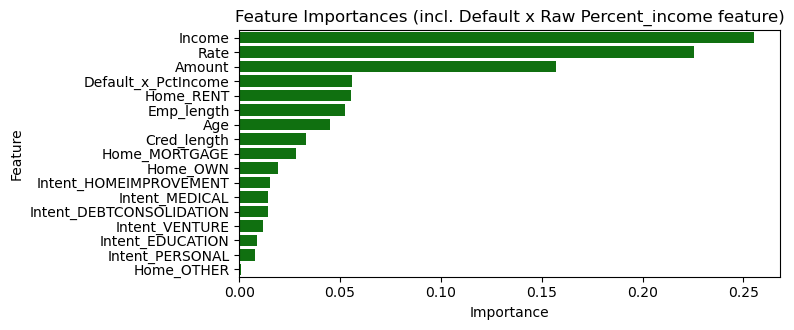

In [55]:
# RANDOM FOREST STATUS TARGET - DEFAULT x RAW PERCENT INCOME GENERATED FEATURE
df_rf = df_encoded.copy()
df_rf['Default_x_PctIncome'] = df_rf['Default'] * df_rf['Percent_income']
target = 'Status'
drop_cols = ['Percent_income', 'Default'] 
#predictors = [col for col in df_rf.columns if col != target]
predictors = [col for col in df_rf.columns if col not in drop_cols + [target]]
X = df_rf[predictors]
y = df_rf[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 50],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced', {0: 1, 1: 3}, {0: 1, 1: 5}]}

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=0)
random_search.fit(X_train, y_train)
best_rf_defxrawpi = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

y_pred = best_rf_defxrawpi.predict(X_test)
y_proba = best_rf_defxrawpi.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})', color='darkorange')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

importances = pd.Series(best_rf_defxrawpi.feature_importances_, index=predictors).sort_values(ascending=False)

plt.figure(figsize=(8, len(importances) * 0.2)) 
sns.barplot(x=importances.values, y=importances.index, color='green')
plt.title("Feature Importances (incl. Default x Raw Percent_income feature)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5066
           1       0.92      0.70      0.79      1418

    accuracy                           0.92      6484
   macro avg       0.92      0.84      0.87      6484
weighted avg       0.92      0.92      0.92      6484



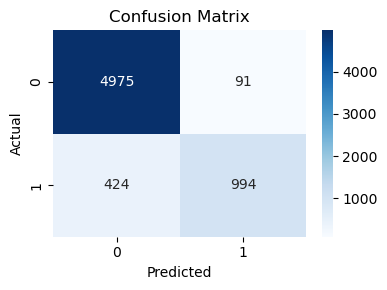

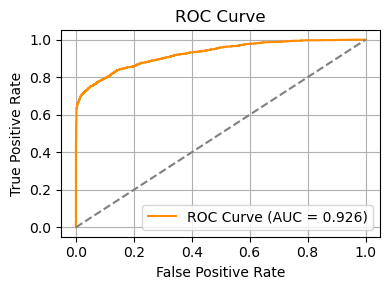

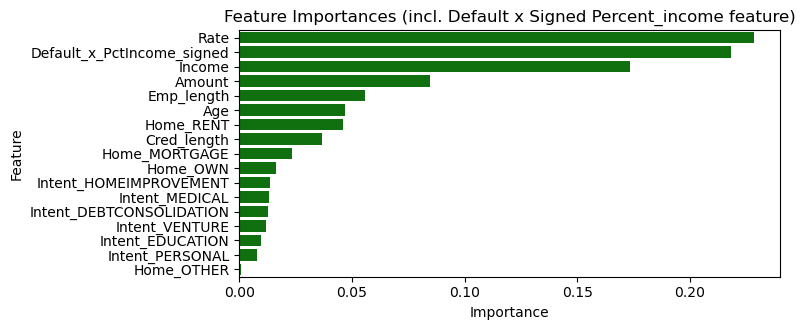

In [56]:
# RANDOM FOREST STATUS TARGET - DEFAULT x SIGNED PERCENT INCOME GENERATED FEATURE
df_rf = df_encoded.copy()
df_rf['Default_x_PctIncome_signed'] = df_rf.apply(lambda row: -row['Percent_income'] if row['Default'] == 0 else row['Percent_income'], axis=1)
target = 'Status'
drop_cols = ['Percent_income', 'Default'] 
#predictors = [col for col in df_rf.columns if col != target]
predictors = [col for col in df_rf.columns if col not in drop_cols + [target]]
X = df_rf[predictors]
y = df_rf[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 50],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced', {0: 1, 1: 3}, {0: 1, 1: 5}]}

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=0)
random_search.fit(X_train, y_train)
best_rf_defxsigned = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

y_pred = best_rf_defxsigned.predict(X_test)
y_proba = best_rf_defxsigned.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})', color='darkorange')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

importances = pd.Series(best_rf_defxsigned.feature_importances_, index=predictors).sort_values(ascending=False)

plt.figure(figsize=(8, len(importances) * 0.2))
sns.barplot(x=importances.values, y=importances.index, color='green')
plt.title("Feature Importances (incl. Default x Signed Percent_income feature)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

**I then decided to tune the decision threshold since this directly affects the classification of a client as positive (defaulter) or negative (non-defaulter) and thus directly impacts *Precision* (Class 1) and *Recall* (Class 1). I generated a Precision and Recall vs. Threshold curve to easily examine how the decision threshold influences the distribution of scores for *Precision* and *Recall*. Next, I quickly evaluated our model using different thresholds (0.5, 0.4, 0.3, 0.2, 0.1). The results confirmed what the plot also visualized: as *Precision* rises, *Recall* falls, and vice versa. Below a threshold of 0.4, *Recall* (Class 1) starts to increase substantially; however, this is coupled with an even more significant deterioration in *Precision* (Class 1). Furthermore, despite *Recall* reaching 0.95 at a threshold of 0.1, the F1 score has completely cratered to 0.52, indicating a severe imbalance between the two metrics.**


Threshold: 0.50
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5066
           1       0.91      0.70      0.79      1418

    accuracy                           0.92      6484
   macro avg       0.92      0.84      0.87      6484
weighted avg       0.92      0.92      0.92      6484

Confusion Matrix:
[[4972   94]
 [ 429  989]]

Threshold: 0.40
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      5066
           1       0.84      0.74      0.79      1418

    accuracy                           0.91      6484
   macro avg       0.89      0.85      0.87      6484
weighted avg       0.91      0.91      0.91      6484

Confusion Matrix:
[[4871  195]
 [ 370 1048]]

Threshold: 0.30
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      5066
           1       0.71    

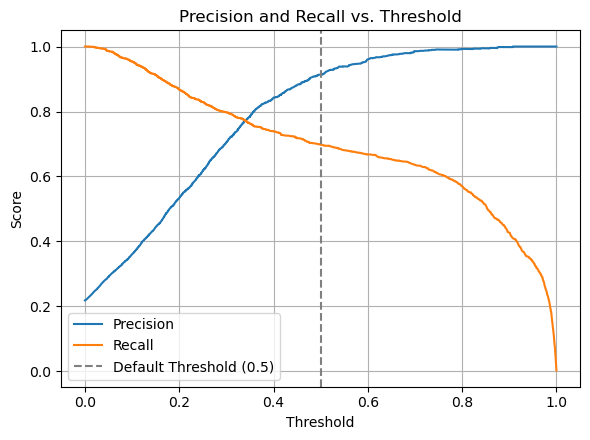

In [58]:
df_rf_status = df_encoded.copy()
target = 'Status'
predictors_all = [col for col in df_rf_status.columns if col != target]
X_all = df_rf_status[predictors_all]
y_all = df_rf_status[target]

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)
y_proba_all = best_rf_all.predict_proba(X_test_all)[:, 1]

def evaluate_thresholds(model_name, y_true, y_proba, thresholds=[0.5, 0.4, 0.3, 0.2, 0.1]):
    for t in thresholds:
        y_pred_thresh = (y_proba >= t).astype(int)
        print(f"\nThreshold: {t:.2f}")
        print("Classification Report:")
        print(classification_report(y_true, y_pred_thresh))
        print("Confusion Matrix:")
        print(confusion_matrix(y_true, y_pred_thresh))

evaluate_thresholds("best_rf_all", y_test_all, y_proba_all)
precision, recall, thresholds = precision_recall_curve(y_test_all, y_proba_all)

plt.figure(figsize=(6, 4.5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(0.5, color='gray', linestyle='--', label='Default Threshold (0.5)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **REAL WORLD APPLICATION (EARNINGS COMPUTATIONS)**

**Despite extensive hyperparameter tuning, feature engineering, and threshold adjustment, *Recall* (Class 1) only improved substantially at the expense of *Precision* for the same class. This trade-off is expected, as the more aggressively the model tries to identify actual defaulters, the higher the chance of wrongly tagging good payers as high risk. The Precision and Recall vs. Threshold curve elegantly demonstrates this inverse relationship, while also showing a point where the two metrics intersect, representing a theoretical "sweet spot." However, in practice, the ideal balance depends heavily on the company’s goals and risk tolerance. Therefore, for our analyses to be useful, I projected the financial impact of varying *Precision* and *Recall* values.**

**Both metrics relate to identifying true defaulters, so carefully tuning them directly affects how much capital loss can be avoided and how much potential revenue might be missed. As previously stated, *Precision* (Class 1) measures how accurately the model predicts high-risk individuals, who are the ones the company might avoid lending to in order to minimize losses. On the other hand, *Recall* (Class 1) measures how many actual defaulters were caught by the model. Ideally, a lender would want to attain a high *Recall* so that high-risk borrowers do not slip through, thereby preventing unpaid loans and direct capital losses. However, while a high *Recall* means reduced default risk, it can also lead to missed income if good payers are mistakenly declined.**

**To simulate real-world scenarios, I applied the different thresholds from model training and then estimated losses by considering false positives (good payers wrongly tagged as defaulters) receiving the median loan amount for defaulters, and false negatives (defaulters wrongly tagged as good payers) receiving the median loan for good payers. Not surprisingly, an inverse relationship was evident, where efforts to mitigate unpaid loans resulted in increased missed revenue, and vice versa. Assuming that the lender declined clients tagged as high-risk, the lowest projected total loss was observed at the 0.5 threshold, with *Precision* at 0.91 and *Recall* at 0.70. At a more aggressive threshold of 0.1, where *Recall* reached 0.95, losses from unpaid loans were reduced by roughly 85%. However, missed revenue ballooned exponentially to more than $23 million due to the model wrongly tagging and rejecting actual good payers.**

**This analysis highlights the complex nuances and trade-offs companies face when selecting a model and decision threshold. A lender using a strict, binary loan approval policy may prefer a higher *Precision* to avoid missed opportunities, even if that means failing to catch some defaulters. Alternatively, a more refined approach could involve accepting a higher *Recall* to aggressively identify high-risk clients while still offering modified or even customized loan terms to these flagged individuals. This would allow the company to earn revenue from some wrongly classified good payers and also gather more data for improved risk modeling.**

In [61]:
median_loan_paid = df_encoded.loc[df_encoded['Status'] == 0, 'Amount'].median()
median_loan_default = df_encoded.loc[df_encoded['Status'] == 1, 'Amount'].median()

print(f"Median loan amount for payers (Status=0): ${median_loan_paid:,.2f}")
print(f"Median loan amount for defaulters (Status=1): ${median_loan_default:,.2f}")

cost_FN = median_loan_paid
cost_FP = median_loan_default

X_all = df_encoded[best_rf_all.feature_names_in_]
y_all = df_encoded['Status']
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)

def calculate_losses(model, X, y_true, thresholds, cost_fn, cost_fp):
    y_proba = model.predict_proba(X)[:, 1]
    results = []

    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        loss_fn = fn * cost_fn
        loss_fp = fp * cost_fp
        total_loss = loss_fn + loss_fp
        results.append({
            'Threshold': threshold,
            'False Negatives': fn,
            'False Positives': fp,
            'Loss FN (Unpaid Loans)': loss_fn,
            'Loss FP (Missed Gains)': loss_fp,
            'Total Loss': total_loss})
    return pd.DataFrame(results)

thresholds_to_test = [0.5, 0.4, 0.3, 0.2, 0.1]
loss_df = calculate_losses(best_rf_all, X_test_all, y_test_all, thresholds_to_test, cost_FN, cost_FP)

for col in ['Loss FN (Unpaid Loans)', 'Loss FP (Missed Gains)', 'Total Loss']:
    loss_df[col] = loss_df[col].map('${:,.2f}'.format)

loss_df

Median loan amount for payers (Status=0): $8,000.00
Median loan amount for defaulters (Status=1): $9,600.00


,Threshold,False Negatives,False Positives,Loss FN (Unpaid Loans),Loss FP (Missed Gains),Total Loss
0,0.5,429,94,"$3,432,000.00","$902,400.00","$4,334,400.00"
1,0.4,370,195,"$2,960,000.00","$1,872,000.00","$4,832,000.00"
2,0.3,287,472,"$2,296,000.00","$4,531,200.00","$6,827,200.00"
3,0.2,188,1074,"$1,504,000.00","$10,310,400.00","$11,814,400.00"
4,0.1,65,2401,"$520,000.00","$23,049,600.00","$23,569,600.00"


**At this stage, the lender can determine which threshold to apply, depending on their risk appetite. However, instead of using a fixed threshold, I decided to use the model's predicted probabilities to create custom risk tiers: Low Risk, Medium Risk, and High Risk. Each tier was assigned a custom loan amount and interest rate, which can be adjusted based on how the lender wants to allocate capital and manage risk. Using these custom values, I simulated net profit and loss on the model’s predictions for the test set. To better understand the financial impact, I included intermediate metrics, such as principal repaid and interest income, to the summary table. Assuming that defaulters repay nothing (i.e., default from month one), the results showed that only Low Risk clients yielded a profit.**

**For the Medium Risk group, with over 1,000 clients, a loss exceeding \\$765,000 would be incurred from a total capital outlay of over \$10 million, assuming all 182 defaulters failed to repay any portion of their loans. However, if those defaulters had managed to repay even half their loan, the lender would be slightly in the green. In stark contrast, the High Risk tier proved to be economically unviable, with more than 84% of borrowers defaulting, resulting in a substantial loss regardless of repayment assumptions.**

In [63]:
X_all = df_encoded[best_rf_all.feature_names_in_]
y_all = df_encoded['Status']
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)
y_proba = best_rf_all.predict_proba(X_test_all)[:, 1]

risk_df = X_test_all.copy()
risk_df['True_Status'] = y_test_all
risk_df['Prob_Default'] = y_proba

def assign_risk_tier(prob):
    if prob <= 0.20: # tune this
        return 'Low'
    elif prob <= 0.40: # tune this
        return 'Medium'
    else:
        return 'High'

risk_df['Risk_Tier'] = risk_df['Prob_Default'].apply(assign_risk_tier)
risk_df['Status'] = y_test_all.values
loan_amounts = {'Low': 20000, 'Medium': 10000, 'High': 5000} # tune this
interest_rates = {'Low': 0.10, 'Medium': 0.12, 'High': 0.14} # tune this
risk_df['Loan_Amount'] = risk_df['Risk_Tier'].map(loan_amounts)
risk_df['Interest_Rate'] = risk_df['Risk_Tier'].map(interest_rates)
risk_df['Principal_Repaid'] = risk_df.apply(lambda row: row['Loan_Amount'] if row['Status'] == 0 else 0, axis=1)
risk_df['Interest_Income'] = risk_df.apply(lambda row: row['Loan_Amount'] * row['Interest_Rate'] if row['Status'] == 0 else 0, axis=1)
risk_df['Principal_Lost'] = risk_df.apply(lambda row: row['Loan_Amount'] if row['Status'] == 1 else 0, axis=1)

summary = risk_df.groupby('Risk_Tier').agg(
    Borrowers=('Loan_Amount', 'count'),
    Loan_Amount=('Loan_Amount', 'first'),
    Interest_Rate=('Interest_Rate', 'first'),
    Defaults=('Status', lambda x: (x == 1).sum()),
    Principal_Repaid=('Principal_Repaid', 'sum'),
    Interest_Income=('Interest_Income', 'sum'),
    Principal_Lost=('Principal_Lost', 'sum')).reset_index()

summary['Total_Lent'] = summary['Borrowers'] * summary['Loan_Amount']
summary['Total_Revenue'] = summary['Principal_Repaid'] + summary['Interest_Income']
summary['Net_Profit_or_Loss'] = summary['Interest_Income'] - summary['Principal_Lost']
summary['Default_Rate'] = ((summary['Defaults'] / summary['Borrowers']) * 100).map("{:.2f}%".format)
summary['Loan_Yield'] = ((summary['Net_Profit_or_Loss'] / summary['Total_Lent']) * 100).map("{:.2f}%".format)
summary['Interest_Rate'] = summary['Interest_Rate'].apply(lambda x: f"{x*100:.0f}%")

currency_cols = ['Loan_Amount', 'Total_Lent', 'Principal_Repaid', 'Interest_Income', 'Total_Revenue', 'Net_Profit_or_Loss']

for col in currency_cols:
    summary[col] = summary[col].apply(lambda x: f"${x:,.2f}")

summary = summary[['Risk_Tier', 'Borrowers', 'Loan_Amount', 'Total_Lent', 'Interest_Rate', 'Defaults', 'Default_Rate',
                   'Principal_Repaid', 'Interest_Income', 'Total_Revenue', 'Net_Profit_or_Loss', 'Loan_Yield']]
risk_order = ['Low', 'Medium', 'High']
summary['Risk_Tier'] = pd.Categorical(summary['Risk_Tier'], categories=risk_order, ordered=True)
summary = summary.sort_values('Risk_Tier').reset_index(drop=True)
summary

,Risk_Tier,Borrowers,Loan_Amount,Total_Lent,Interest_Rate,Defaults,Default_Rate,Principal_Repaid,Interest_Income,Total_Revenue,Net_Profit_or_Loss,Loan_Yield
0,Low,4180,"$20,000.00","$83,600,000.00",10%,188,4.50%,"$79,840,000.00","$7,984,000.00","$87,824,000.00","$4,224,000.00",5.05%
1,Medium,1061,"$10,000.00","$10,610,000.00",12%,182,17.15%,"$8,790,000.00","$1,054,800.00","$9,844,800.00","$-765,200.00",-7.21%
2,High,1243,"$5,000.00","$6,215,000.00",14%,1048,84.31%,"$975,000.00","$136,500.00","$1,111,500.00","$-5,103,500.00",-82.12%


**I repeated the same analysis using the entire dataset to evaluate whether profitability would improve when client volume was scaled up. True enough, given sufficient capital to accommodate more borrowers, even the Medium Risk tier yielded a reasonable profit. What stood out, however, was the significant shift in default rates, even though the same custom risk tiers were used. The actual default rate for the Low Risk tier dropped drastically to just 0.83%, demonstrating that the model can almost perfectly identify reliable borrowers. Conversely, the default rate for the High Risk group surged to nearly 94%, indicating that the model is also highly effective at flagging borrowers who are very likely to default.**

**This performance reflects what we observed in the ROC curve, which consistently showed high values throughout the various hyperparameter tuning experiments. In practice, these results demonstrate that the model is not only statistically robust, but also highly practical for risk-based decision-making in a real-world lending context.**

In [65]:
X_all = df_encoded.drop(columns=['Status'])
y_all = df_encoded['Status']
y_proba_all = best_rf_all.predict_proba(X_all)[:, 1]

risk_df_full = X_all.copy()
risk_df_full['Prob_Default'] = y_proba_all
risk_df_full['Status'] = y_all

def assign_risk_tier(prob):
    if prob <= 0.20: # tune this
        return 'Low'
    elif prob <= 0.40: # tune this
        return 'Medium'
    else:
        return 'High'

risk_df_full['Risk_Tier'] = risk_df_full['Prob_Default'].apply(assign_risk_tier)
loan_amounts = {'Low': 20000, 'Medium': 10000, 'High': 5000} # tune this
interest_rates = {'Low': 0.10, 'Medium': 0.12, 'High': 0.14} # tune this
risk_df_full['Loan_Amount'] = risk_df_full['Risk_Tier'].map(loan_amounts)
risk_df_full['Interest_Rate'] = risk_df_full['Risk_Tier'].map(interest_rates)
risk_df_full['Principal_Repaid'] = risk_df_full.apply(lambda row: row['Loan_Amount'] if row['Status'] == 0 else 0, axis=1)
risk_df_full['Interest_Income'] = risk_df_full.apply(lambda row: row['Loan_Amount'] * row['Interest_Rate'] if row['Status'] == 0 else 0, axis=1)
risk_df_full['Principal_Lost'] = risk_df_full.apply(lambda row: row['Loan_Amount'] if row['Status'] == 1 else 0, axis=1)
risk_df_full['Total_Revenue'] = risk_df_full['Principal_Repaid'] + risk_df_full['Interest_Income']
risk_df_full['Net_Profit_or_Loss'] = risk_df_full['Interest_Income'] - risk_df_full['Principal_Lost']

summary_all = risk_df_full.groupby('Risk_Tier').agg(
    Borrowers=('Loan_Amount', 'count'),
    Loan_Amount=('Loan_Amount', 'first'),
    Interest_Rate=('Interest_Rate', 'first'),
    Defaults=('Status', lambda x: (x == 1).sum()),
    Principal_Repaid=('Principal_Repaid', 'sum'),
    Interest_Income=('Interest_Income', 'sum'),
    Principal_Lost=('Principal_Lost', 'sum'),).reset_index()

summary_all['Total_Lent'] = summary_all['Borrowers'] * summary_all['Loan_Amount']
summary_all['Total_Revenue'] = summary_all['Principal_Repaid'] + summary_all['Interest_Income']
summary_all['Net_Profit_or_Loss'] = summary_all['Interest_Income'] - summary_all['Principal_Lost']
summary_all['Default_Rate'] = ((summary_all['Defaults'] / summary_all['Borrowers']) * 100).map("{:.2f}%".format)
summary_all['Loan_Yield'] = ((summary_all['Net_Profit_or_Loss'] / summary_all['Total_Lent']) * 100).map("{:.2f}%".format)
summary_all['Interest_Rate'] = summary_all['Interest_Rate'].apply(lambda x: f"{x*100:.0f}%")

currency_cols = ['Loan_Amount', 'Total_Lent', 'Principal_Repaid', 'Interest_Income', 'Total_Revenue', 'Net_Profit_or_Loss']

for col in currency_cols:
    summary_all[col] = summary_all[col].apply(lambda x: f"${x:,.2f}")

summary_all = summary_all[['Risk_Tier', 'Borrowers', 'Loan_Amount', 'Total_Lent', 'Interest_Rate', 'Defaults', 'Default_Rate',
                           'Principal_Repaid', 'Interest_Income', 'Total_Revenue', 'Net_Profit_or_Loss', 'Loan_Yield']]
risk_order = ['Low', 'Medium', 'High']
summary_all['Risk_Tier'] = pd.Categorical(summary_all['Risk_Tier'], categories=risk_order, ordered=True)
summary_all = summary_all.sort_values('Risk_Tier').reset_index(drop=True)
summary_all

,Risk_Tier,Borrowers,Loan_Amount,Total_Lent,Interest_Rate,Defaults,Default_Rate,Principal_Repaid,Interest_Income,Total_Revenue,Net_Profit_or_Loss,Loan_Yield
0,Low,22544,"$20,000.00","$450,880,000.00",10%,188,0.83%,"$447,120,000.00","$44,712,000.00","$491,832,000.00","$40,952,000.00",9.08%
1,Medium,2709,"$10,000.00","$27,090,000.00",12%,182,6.72%,"$25,270,000.00","$3,032,400.00","$28,302,400.00","$1,212,400.00",4.48%
2,High,7163,"$5,000.00","$35,815,000.00",14%,6719,93.80%,"$2,220,000.00","$310,800.00","$2,530,800.00","$-33,284,200.00",-92.93%


**After extensive tuning of the loan attribute levers (risk tiering, loan amount, and interest rate), I found that there is no combination in which lending to the High Risk tier results in a profit. This is particularly true under the assumption that the lender is unable to collect any payments from borrowers starting from month one. Based on this insight, we can now shift the resource allocation strategy toward better serving the Low and Medium Risk tiers.**

**To guide this shift, I created a summary estimating the amount of capital required to serve all Low and Medium Risk clients. It also includes projected net profit or loss, as well as the overall loan yield based on the total capital deployed. This summary allows the lender to quickly determine the optimal balance of risk tiering, loan amount, and interest rate that aligns with their available capital. Alternatively, it can be used to estimate how much capital would be needed to achieve a target profit or percent yield. Using the risk tier, loan amount, and interest rate tuning that I set, the strategy yields over \\$42 million (8.82% loan yield) in net profit from approximately \$478 million in capital lent to over 25,000 clients.**

In [70]:
low_med_totals = summary_all[summary_all['Risk_Tier'].isin(['Low', 'Medium'])].copy()
low_med_totals['Total_Lent'] = low_med_totals['Total_Lent'].replace(r'[\$,]', '', regex=True).astype(float)
low_med_totals['Net_Profit_or_Loss'] = low_med_totals['Net_Profit_or_Loss'].replace(r'[\$,]', '', regex=True).astype(float)
total_lent_lm = low_med_totals['Total_Lent'].sum()
net_profit_lm = low_med_totals['Net_Profit_or_Loss'].sum()
loan_yield_lm = (net_profit_lm / total_lent_lm) * 100 if total_lent_lm != 0 else 0

print("------ Low and Medium Risk Tier Totals ------")
print(f"Total Amount Lent: ${total_lent_lm:,.2f}")
print(f"Total Net Profit or Loss: ${net_profit_lm:,.2f}")
print(f"Loan Yield: {loan_yield_lm:.2f}%")

------ Low and Medium Risk Tier Totals ------
Total Amount Lent: $477,970,000.00
Total Net Profit or Loss: $42,164,400.00
Loan Yield: 8.82%


**Lastly, I created a summary of the typical attribute values for clients within each risk tier. While most mean and median values are quite similar across tiers, there is a clear distinction in income and loan-to-income ratio (*Percent_income*) between the low- and medium-risk tiers compared to the high-risk tier. In essence, clients with an income of $50,000 who borrow an amount equal to one-fifth or less of their income tend to project as profitable for the lender.**

In [73]:
profile_cols = ['Age', 'Income', 'Amount', 'Rate', 'Percent_income', 'Emp_length', 'Cred_length'] 
client_profiles = risk_df_full.groupby('Risk_Tier')[profile_cols].agg(['mean', 'median'])
client_profiles = client_profiles.loc[['Low', 'Medium', 'High']]
client_profiles = client_profiles.round(2)
client_profiles

Age           Income             Amount           Rate         \
            mean median      mean   median      mean  median   mean median   
Risk_Tier                                                                    
Low        27.83   26.0  72989.81  61000.0   9269.20  8000.0  10.03  10.08   
Medium     27.67   26.0  55020.16  45000.0   9044.25  7150.0  13.42  13.79   
High       27.44   25.0  48568.29  40525.0  10823.46  9600.0  13.26  13.98   

          Percent_income        Emp_length        Cred_length         
                    mean median       mean median        mean median  
Risk_Tier                                                             
Low                 0.15   0.13       5.02    4.0        5.86    4.0  
Medium              0.18   0.16       4.72    4.0        5.81    4.0  
High                0.25   0.24       4.05    3.0        5.66    4.0

**In conclusion, this project showcased the potential of applying modern data science techniques to credit risk assessment. Through comprehensive analysis and strategy-guided modeling, it demonstrated how lenders can make more flexible yet informed, data-driven decisions that effectively reduce risk and, more importantly, improve profit potential.**

**Throughout the project, we determined that the available data categories do not, either individually or collectively, influence the interest rate or loan amount offered by lenders. We also identified interest rate, loan-to-income ratio, and previous default status as the most prominent factors associated with high-risk clients. Furthermore, we built a machine learning model that was highly accurate in predicting good payers and defaulters, although it lagged a bit in catching actual defaulters. Nevertheless, we mitigated the risk of misclassifying defaulters as good payers by establishing risk tiers based on the ML model and assigning them respective loan terms. Using this strategy, we simulated nearly a 9% loan yield with less than a 1.5% default rate across all qualified clients. This indicated yield would even be higher considering our very conservative assumption that defaulters were unable to pay any amount. Compared to typical loan yields of large, established lenders at 4-6%, our results from the risk-tiering approach were very promising.**